In [199]:
# !pip install --upgrade --force-reinstall \
#   numpy==1.26.4 \
#   statsmodels\
#   yfinance \
#   pmdarima\
#   arch\
#   ta\
#   TA-Lib

In [200]:
# === B. Imports (run after restarting runtime) ===
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime

#Yahoo finance
import yfinance as yf
# Time series & econometrics
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# GARCH
from arch import arch_model

# Auto-arima (optional later)
import pmdarima as pm

# ML & utilities
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm

# Financial indicators
import ta

# Misc
import scipy.stats as stats
import holidays

print("Environment ready. NumPy:", np.__version__, "pandas:", pd.__version__)

Environment ready. NumPy: 1.26.4 pandas: 2.3.3


# Data Setup

In [201]:
ticker = "BTC-USD"
start_date = "2014-01-01"
print(f"Downloading {ticker} data from {start_date}...")

btc = yf.download(ticker, start=start_date, progress=True)
 #fixing index

if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.get_level_values(0)

btc.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


# Data Cleaning

In [202]:
btc.index = pd.to_datetime(btc.index)

# Drop any rows with missing values
initial_len = len(btc)
btc.dropna(inplace=True)

# Remove any potential duplicate dates
btc = btc[~btc.index.duplicated(keep='first')]

# Ensure sorted order
btc.sort_index(inplace=True)

cleaned_len = len(btc)
print(f"Data Cleaned. Rows: {cleaned_len} (Dropped {initial_len - cleaned_len} NaNs/Duplicates)")

# 4. PREVIEW
print("\nRecent Data:")
print(btc[['Close', 'Volume']].tail())

Data Cleaned. Rows: 4089 (Dropped 0 NaNs/Duplicates)

Recent Data:
Price              Close       Volume
Date                                 
2025-11-22  84648.359375  40793099246
2025-11-23  86805.007812  58083435576
2025-11-24  88270.562500  74433896110
2025-11-25  87341.890625  64837343545
2025-11-26  90149.210938  64383852544


# EDA

In [203]:
print("\n[1] DATA INFO:")
print(btc.info())

print("\n[2] DATA DESCRIPTION:")
print(btc.describe())


[1] DATA INFO:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4089 entries, 2014-09-17 to 2025-11-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4089 non-null   float64
 1   High    4089 non-null   float64
 2   Low     4089 non-null   float64
 3   Open    4089 non-null   float64
 4   Volume  4089 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 191.7 KB
None

[2] DATA DESCRIPTION:
Price          Close           High            Low           Open  \
count    4089.000000    4089.000000    4089.000000    4089.000000   
mean    26314.991615   26825.933391   25730.175846   26294.112752   
std     31253.344477   31777.314030   30664.494893   31240.805068   
min       178.102997     211.731003     171.509995     176.897003   
25%      2601.989990    2693.320068    2518.560059    2602.870117   
50%     10583.134766   10841.887695   10266.008789   10578.198242   
75%     41500.875000   42359.496094   

In [204]:
# We need Log Returns to check for stationarity
btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))
btc.dropna(inplace=True)
btc.head(5)

Price,Close,High,Low,Open,Volume,LogReturn
Date,,,,,,
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,-0.074643
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,-0.072402
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,0.035111
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,-0.024968
2014-09-22,402.152008,406.915985,397.130005,399.100006,24127600,0.008317


In [205]:
def adf_test(series, name):
    print(f"\nPerforming Augmented Dickey-Fuller Test on: {name}")
    result = adfuller(series)
    print(f"   ADF Statistic: {result[0]:.4f}")
    print(f"   p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("   Conclusion: Data is STATIONARY (Ready for modeling)")
    else:
        print("   Conclusion: Data is NON-STATIONARY (Needs differencing/returns)")


In [206]:
# Test Raw Price (Expect Fail)
adf_test(btc['Close'], "Close Price")

# Test Log Returns (Expect Pass)
adf_test(btc['LogReturn'], "Log Returns")


Performing Augmented Dickey-Fuller Test on: Close Price
   ADF Statistic: -0.8720
   p-value: 0.7970
   Conclusion: Data is NON-STATIONARY (Needs differencing/returns)

Performing Augmented Dickey-Fuller Test on: Log Returns
   ADF Statistic: -19.4331
   p-value: 0.0000
   Conclusion: Data is STATIONARY (Ready for modeling)


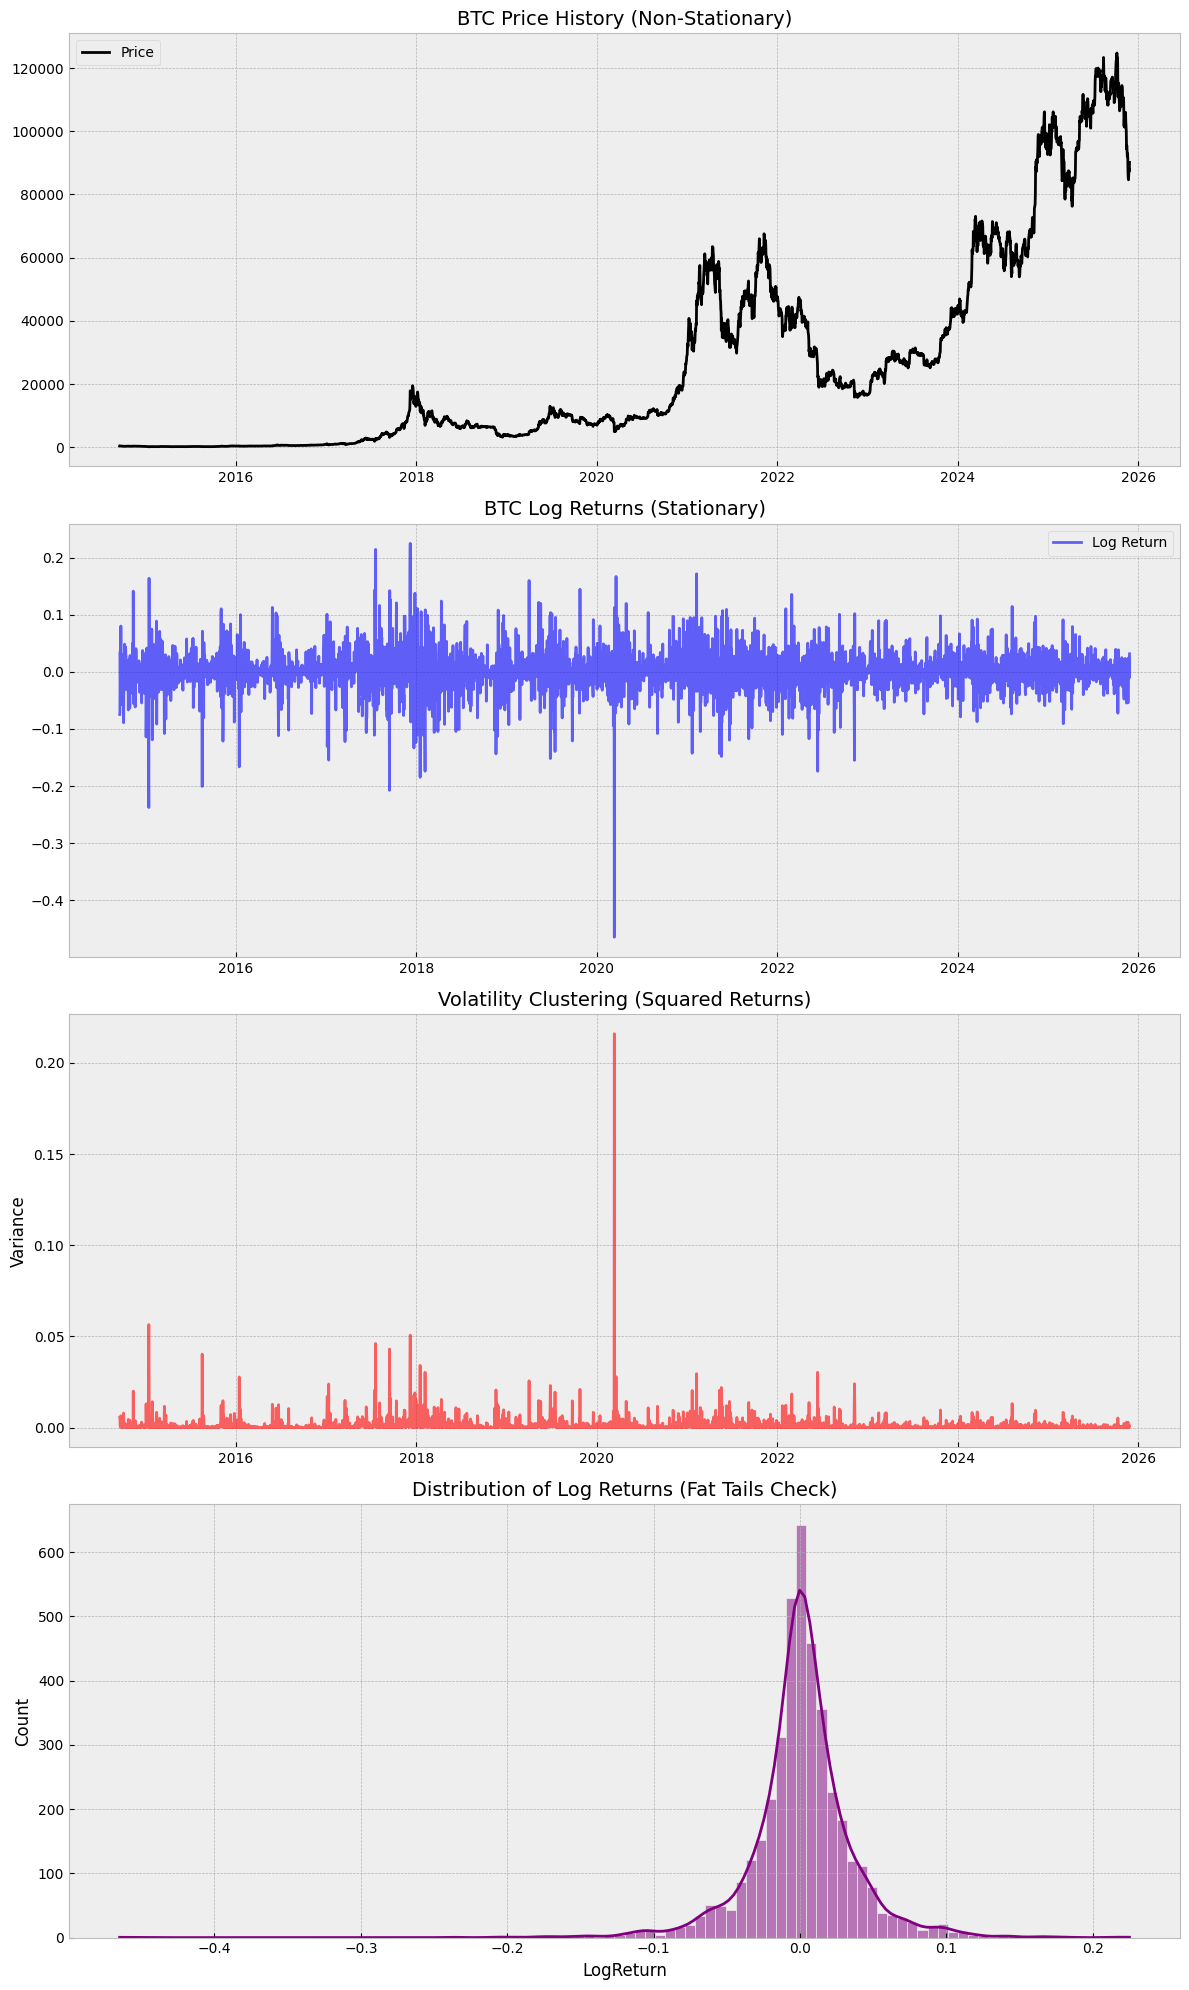

In [207]:
plt.style.use('bmh')
fig, axes = plt.subplots(4, 1, figsize=(12, 20))

# Plot A: Price vs Log Returns
axes[0].plot(btc.index, btc['Close'], color='black', label='Price')
axes[0].set_title('BTC Price History (Non-Stationary)', fontsize=14)
axes[0].legend()

axes[1].plot(btc.index, btc['LogReturn'], color='blue', alpha=0.6, label='Log Return')
axes[1].set_title('BTC Log Returns (Stationary)', fontsize=14)
axes[1].legend()

# Plot B: Volatility Clustering (Squared Returns)
# This justifies using GARCH later. If volatility was constant, this line would be flat.
axes[2].plot(btc.index, btc['LogReturn']**2, color='red', alpha=0.6)
axes[2].set_title('Volatility Clustering (Squared Returns)', fontsize=14)
axes[2].set_ylabel('Variance')

# Plot C: Distribution of Returns
sns.histplot(btc['LogReturn'], kde=True, ax=axes[3], color='purple', bins=100)
axes[3].set_title('Distribution of Log Returns (Fat Tails Check)', fontsize=14)

plt.tight_layout()

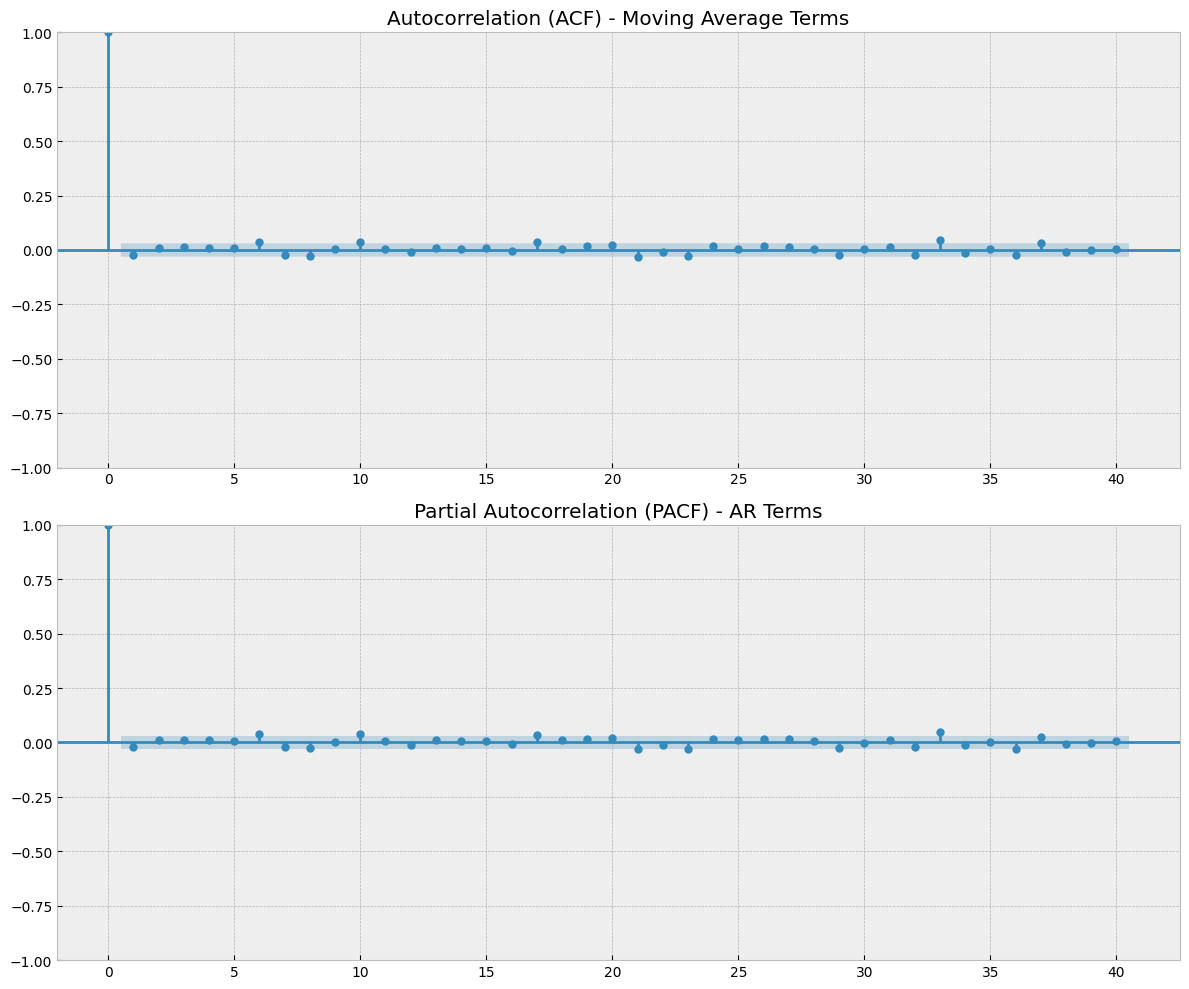

In [208]:
# ACF & PACF PLOTS
# These help determine the (p,d,q) order for ARIMA
# ACF shows moving average impact, PACF shows direct lag impact
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(btc['LogReturn'], lags=40, ax=ax1, title='Autocorrelation (ACF) - Moving Average Terms')
plot_pacf(btc['LogReturn'], lags=40, ax=ax2, title='Partial Autocorrelation (PACF) - AR Terms')

plt.tight_layout()

# Adding Features i.e. Feature Engineering

In [209]:
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    rs = gain / loss
    # rsi = 100 - (100 / (1 + rs))
    # return rsi
    return 100 - (100 / (1 + rs))

In [210]:
# A. Target: Log Return
# btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))
# B. Momentum: RSI (14)
# btc['RSI'] = calculate_rsi(btc['Close'], period=14)
btc['RSI'] = calculate_rsi(btc['Close'])

# C. Risk: Rolling Volatility (30 days)
# We multiply by sqrt(365) to annualize it, though raw std dev is fine too
btc['Rolling_Vol'] = btc['LogReturn'].rolling(window=30).std()

# D. Trend: Distance from SMA (20)
# Positive = Price above trend (Potential pullback)
# Negative = Price below trend (Potential bounce)
btc['SMA_20'] = btc['Close'].rolling(window=20).mean()
btc['Trend_Dist'] = (btc['Close'] / btc['SMA_20']) - 1

# E. Memory: Lagged Returns (The "AR" components)
btc['Lag_1'] = btc['LogReturn'].shift(1)
btc['Lag_2'] = btc['LogReturn'].shift(2)
btc['Lag_3'] = btc['LogReturn'].shift(3)

In [211]:
initial_len = len(btc)
btc.dropna(inplace=True)
print(f"Features Created. Data trimmed from {initial_len} to {len(btc)} rows.")

Features Created. Data trimmed from 4088 to 4059 rows.


# Feature Visualization

Text(0.5, 1.0, 'Feature Correlation Matrix')

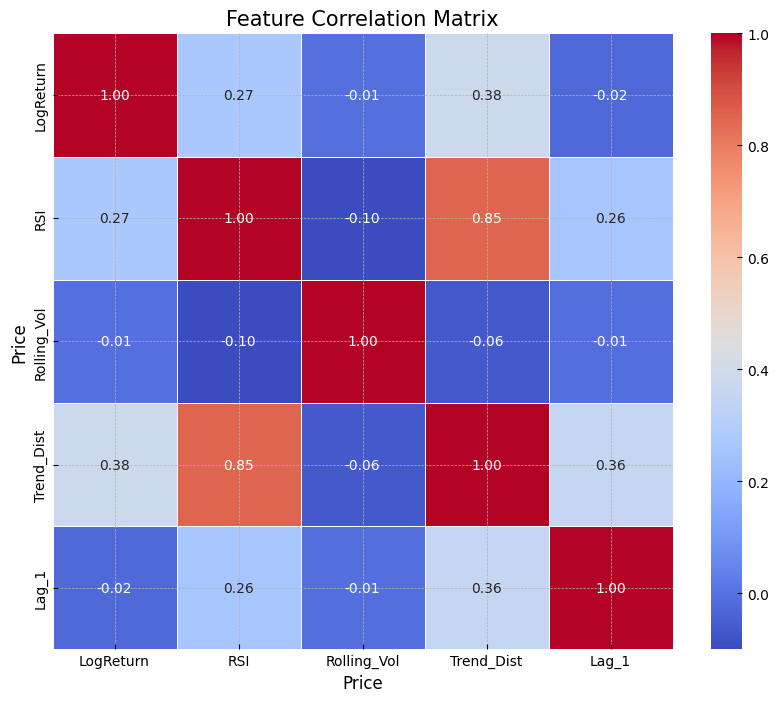

In [212]:
# We want to see if our features correlate with 'LogReturn'
plt.figure(figsize=(10, 8))
corr_matrix = btc[['LogReturn', 'RSI', 'Rolling_Vol', 'Trend_Dist', 'Lag_1']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=15)

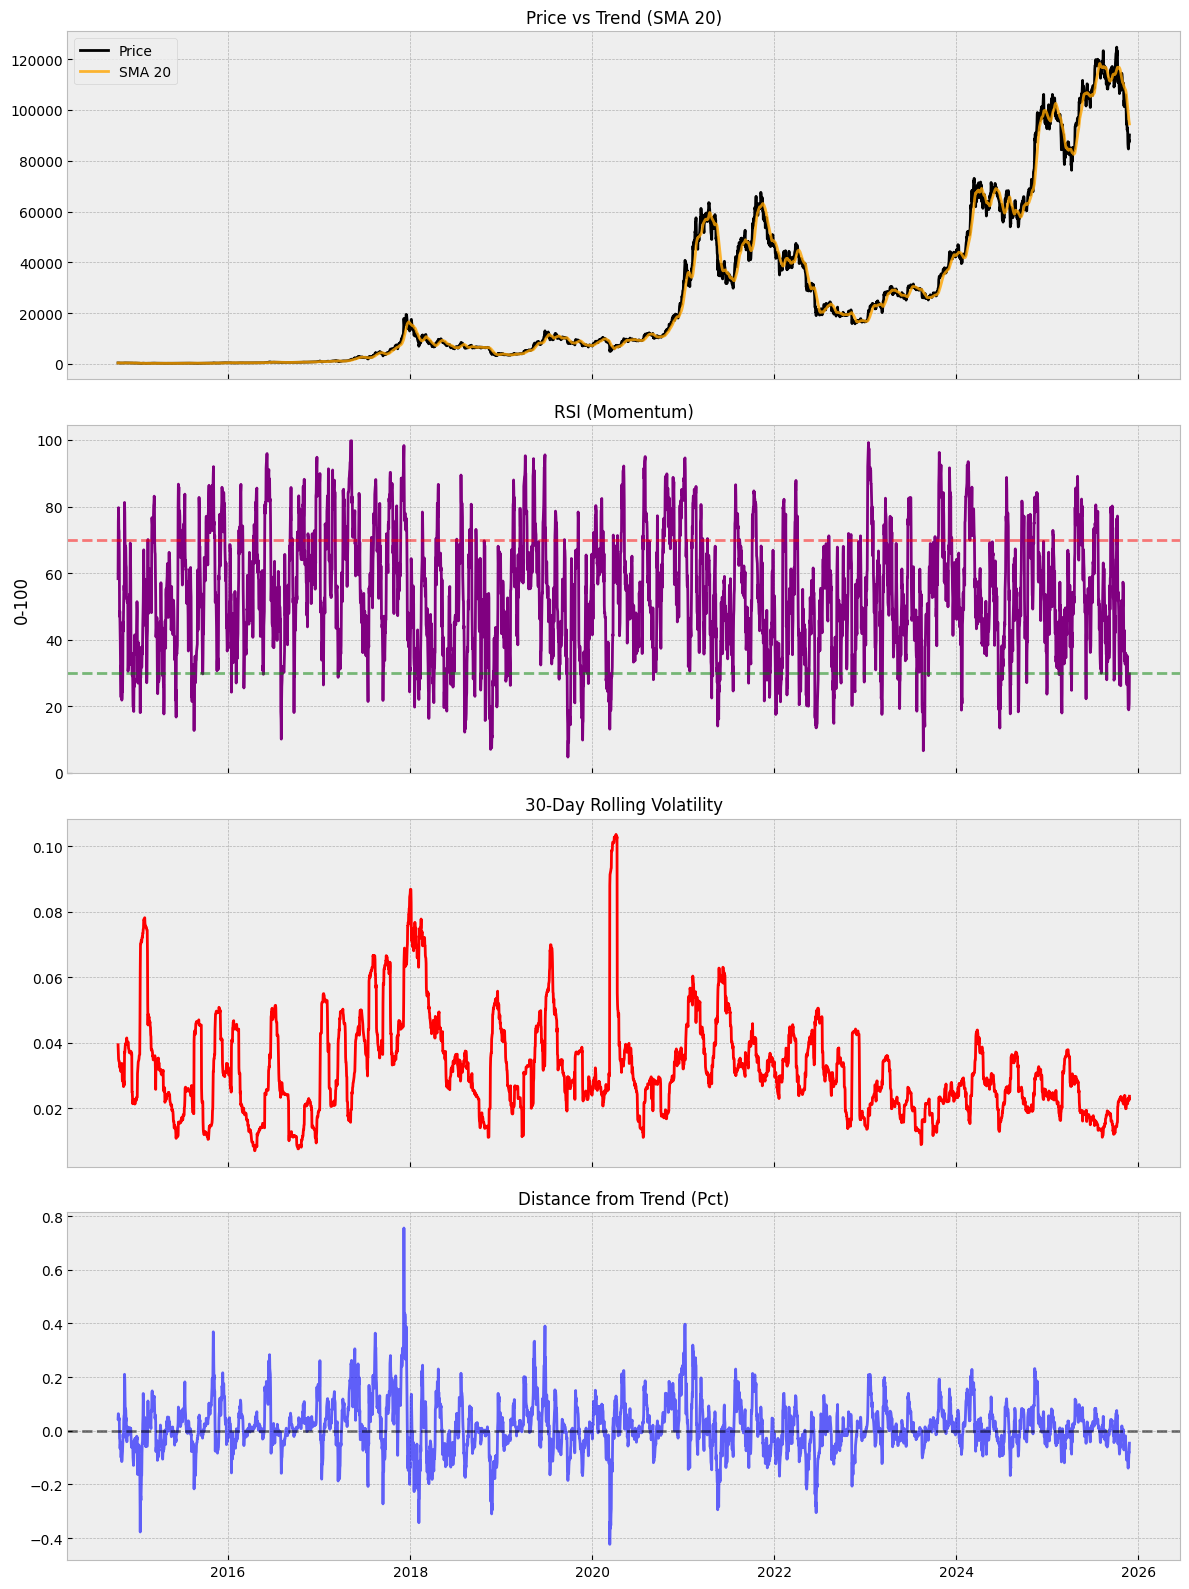

In [213]:
# Plot B: Feature Overview
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# 1. Price & Trend
axes[0].plot(btc.index, btc['Close'], label='Price', color='black')
axes[0].plot(btc.index, btc['SMA_20'], label='SMA 20', color='orange', alpha=0.8)
axes[0].set_title('Price vs Trend (SMA 20)', fontsize=12)
axes[0].legend(loc='upper left')

# 2. RSI (Momentum)
axes[1].plot(btc.index, btc['RSI'], color='purple')
axes[1].axhline(70, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(30, color='green', linestyle='--', alpha=0.5)
axes[1].set_title('RSI (Momentum)', fontsize=12)
axes[1].set_ylabel('0-100')

# 3. Rolling Volatility (Risk)
axes[2].plot(btc.index, btc['Rolling_Vol'], color='red')
axes[2].set_title('30-Day Rolling Volatility', fontsize=12)

# 4. Trend Distance (Gravity)
axes[3].plot(btc.index, btc['Trend_Dist'], color='blue', alpha=0.6)
axes[3].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[3].set_title('Distance from Trend (Pct)', fontsize=12)

plt.tight_layout()

# Model Creation


In [214]:
# Target: What we want to predict (Log Returns)
y = btc['LogReturn']

# Exogenous (X): The features helping us predict
# NOTE: We exclude 'Lag' features here because ARIMA handles autoregression internally via the 'p' order.
exog_features = ['RSI', 'Rolling_Vol', 'Trend_Dist']
X = btc[exog_features]

# 3. TRAIN-TEST SPLIT (Time Series safe)
train_size = int(len(btc) * 0.8)

# Split Target
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Split Exogenous
X_train_raw, X_test_raw = X.iloc[:train_size], X.iloc[train_size:]

print(f"Training Set: {len(y_train)} days")
print(f"Test Set:     {len(y_test)} days")


Training Set: 3247 days
Test Set:     812 days


Features Scaled (Mean=0, Std=1)

Fitting ARIMAX(1,0,1) Model...
                               SARIMAX Results                                
Dep. Variable:              LogReturn   No. Observations:                 3247
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6318.905
Date:                Wed, 26 Nov 2025   AIC                         -12623.810
Time:                        19:05:56   BIC                         -12581.211
Sample:                    10-17-2014   HQIC                        -12608.549
                         - 09-06-2023                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0013      0.001      1.805      0.071      -0.000       0.003
RSI            -0.0072      0.001     -6.091      0.000      -0.

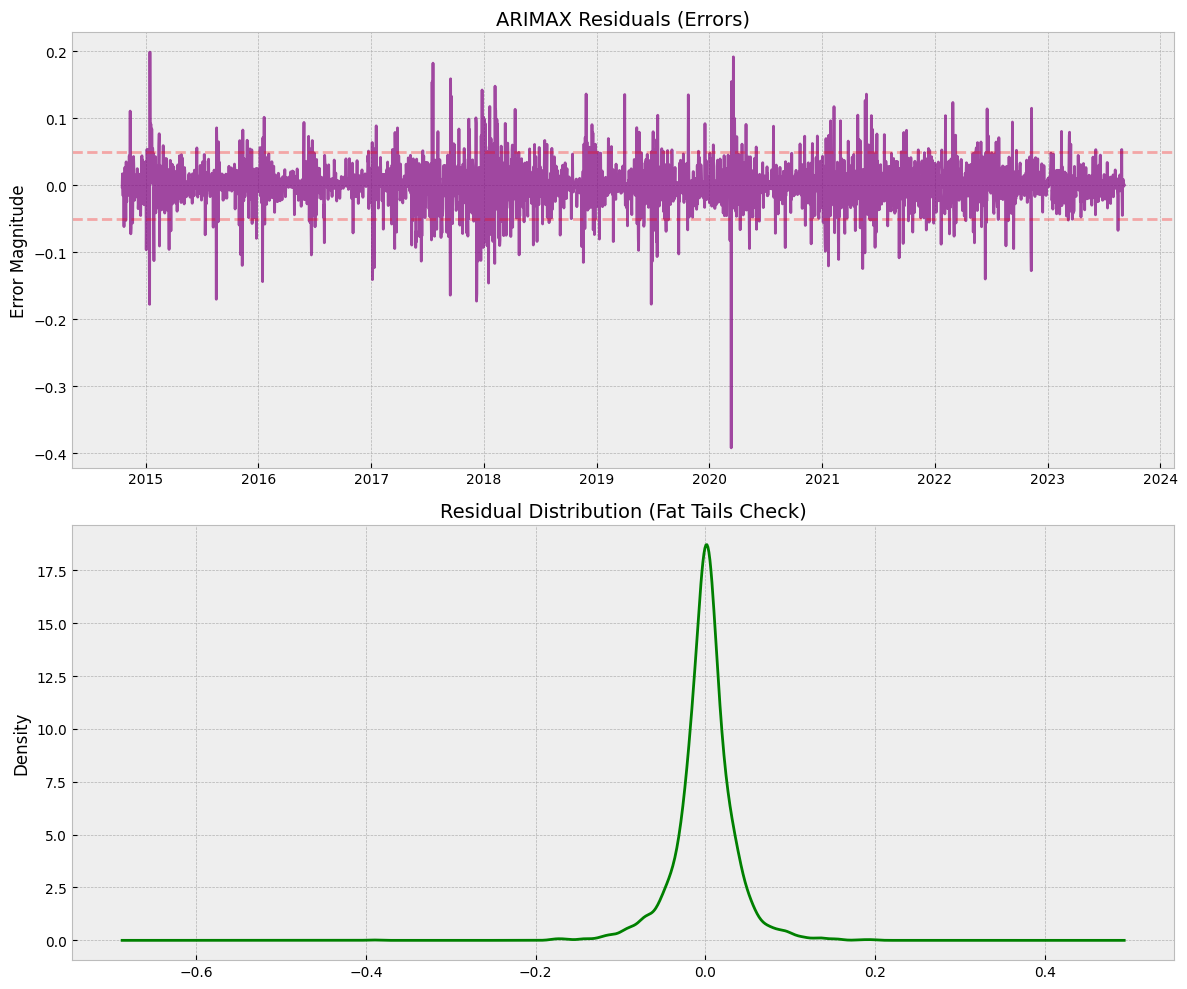

In [215]:
# 4. SCALE EXOGENOUS FEATURES (CRITICAL)
# ARIMA performs poorly if X variables have vastly different scales (e.g., RSI=50 vs Trend=0.01)
scaler = StandardScaler()

# Fit on TRAIN, transform on TEST (to avoid data leakage)
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), index=X_train_raw.index, columns=X_train_raw.columns)
X_test = pd.DataFrame(scaler.transform(X_test_raw), index=X_test_raw.index, columns=X_test_raw.columns)

print("Features Scaled (Mean=0, Std=1)")

# 5. FIT ARIMAX MODEL
# Order (1,0,1) is standard for Log Returns:
# p=1 (Autoregressive), d=0 (Stationary), q=1 (Moving Average)
print("\nFitting ARIMAX(1,0,1) Model...")

model = ARIMA(y_train, exog=X_train, order=(1,0,1))
model_fit = model.fit()

# 6. MODEL SUMMARY & DIAGNOSTICS
print(model_fit.summary())

# 7. RESIDUAL ANALYSIS (Checking if we need GARCH)
residuals = model_fit.resid

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot A: Residuals over time
axes[0].plot(residuals.index, residuals, color='purple', alpha=0.7)
axes[0].set_title('ARIMAX Residuals (Errors)', fontsize=14)
axes[0].set_ylabel('Error Magnitude')
# Add visual cue for volatility clusters
axes[0].axhline(0.05, color='red', linestyle='--', alpha=0.3)
axes[0].axhline(-0.05, color='red', linestyle='--', alpha=0.3)

# Plot B: Distribution of Residuals
residuals.plot(kind='kde', ax=axes[1], color='green', title='Residual Density')
axes[1].set_title('Residual Distribution (Fat Tails Check)', fontsize=14)

plt.tight_layout()

In [216]:
garch_model = arch_model(residuals * 100, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

print(garch_fit.summary().tables[1])

                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0495  4.934e-02      1.003      0.316 [-4.723e-02,  0.146]



--- PHASE 9: PROBABILITY CALIBRATION ---
In-Sample Directional Accuracy: 61.16%


Text(0.5, 0, 'Probability of Return > 0')

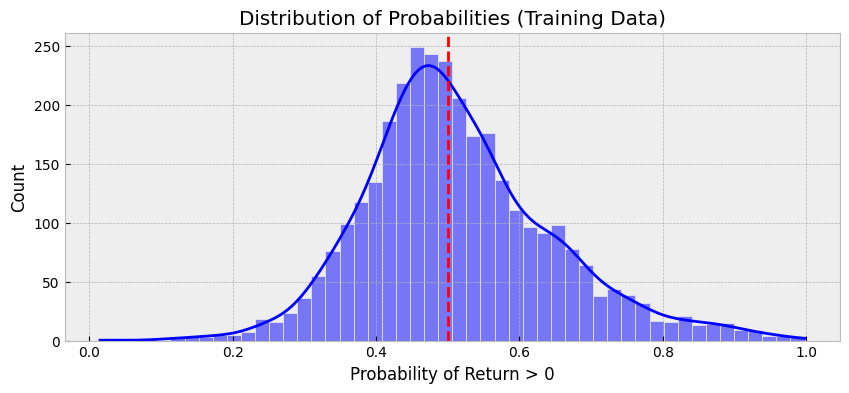

In [217]:

# 2. Get In-Sample Volatility
# Divide by 100 to return to original scale
train_vol = garch_fit.conditional_volatility / 100

# ==========================================
# PHASE 9: PROBABILITY CHECK (IN-SAMPLE)
# ==========================================
print("\n--- PHASE 9: PROBABILITY CALIBRATION ---")

# 1. Get Fitted Mean from your ARIMAX model
# We align indices to ensure GARCH and ARIMAX match (GARCH sometimes drops 1st row)
common_idx = model_fit.fittedvalues.index.intersection(train_vol.index)

# Slice data to common index
mu_train = model_fit.fittedvalues.loc[common_idx]
vol_train = train_vol.loc[common_idx]
actuals_train = y_train.loc[common_idx]

# 2. Calculate Probability (P > 0)
# Z = (0 - Mean) / Vol
z_scores = (0 - mu_train) / vol_train
probs_train = 1 - stats.norm.cdf(z_scores)

# 3. Check Accuracy
pred_dir = (probs_train > 0.5).astype(int)
actual_dir = (actuals_train > 0).astype(int)
acc = (pred_dir == actual_dir).mean()

print(f"In-Sample Directional Accuracy: {acc:.2%}")

# 4. Plot Probability Distribution
plt.figure(figsize=(10, 4))
sns.histplot(probs_train, bins=50, kde=True, color='blue')
plt.axvline(0.5, color='red', linestyle='--')
plt.title('Distribution of Probabilities (Training Data)')
plt.xlabel('Probability of Return > 0')

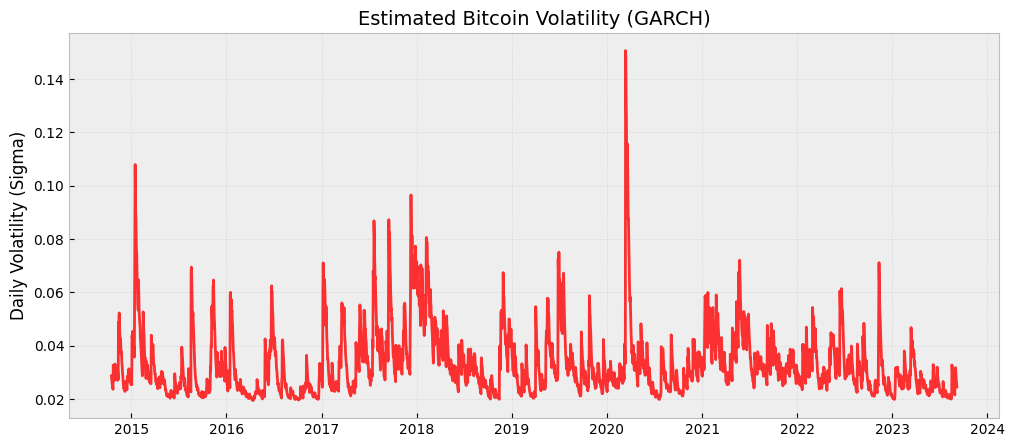

In [218]:
# We divide by 100 to get back to the original scale
conditional_volatility = garch_fit.conditional_volatility / 100

# Plot the "Risk" (Volatility) over time
plt.figure(figsize=(12, 5))
plt.plot(conditional_volatility.index, conditional_volatility, color='red', alpha=0.8)
plt.title('Estimated Bitcoin Volatility (GARCH)', fontsize=14)
plt.ylabel('Daily Volatility (Sigma)')
plt.grid(True, alpha=0.3)


In-Sample Directional Accuracy: 61.16%
   - Red Plot: Shows periods of high risk (GARCH).
   - Accuracy: Shows how well the model fit the training data.
   - Histogram: Shows if the model is confident (spread out) or confused (clustered at 0.5).


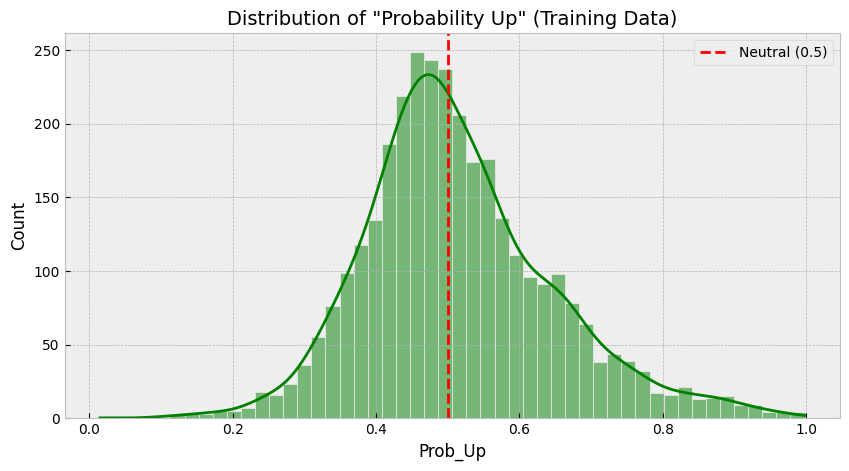

In [219]:
# We align the indices just in case GARCH trimmed the first data point
common_idx = model_fit.fittedvalues.index.intersection(conditional_volatility.index)

# Get Mean (Direction) and Volatility (Risk) for the training set
mu_train = model_fit.fittedvalues.loc[common_idx]
vol_train = conditional_volatility.loc[common_idx]
actuals_train = y_train.loc[common_idx]

# 4. CALCULATE PROBABILITY OF UP (>0)
# Formula: P(r > 0) = 1 - CDF(0 | mu, sigma)
z_scores = (0 - mu_train) / vol_train
probs_up = 1 - stats.norm.cdf(z_scores)

# Create a DataFrame to check accuracy
analysis_df = pd.DataFrame({
    'Actual': actuals_train,
    'Pred_Mean': mu_train,
    'Pred_Vol': vol_train,
    'Prob_Up': probs_up
})

# 5. GENERATE SIGNALS & CHECK ACCURACY
# If Prob > 0.50, we predict UP (1), else DOWN (0)
analysis_df['Prediction'] = (analysis_df['Prob_Up'] > 0.50).astype(int)
analysis_df['Actual_Dir'] = (analysis_df['Actual'] > 0).astype(int)

# Calculate Directional Accuracy
accuracy = np.mean(analysis_df['Prediction'] == analysis_df['Actual_Dir'])
print(f"In-Sample Directional Accuracy: {accuracy:.2%}")

# 6. VISUALIZE PROBABILITY DISTRIBUTION
plt.figure(figsize=(10, 5))
sns.histplot(analysis_df['Prob_Up'], bins=50, kde=True, color='green')
plt.axvline(0.5, color='red', linestyle='--', label='Neutral (0.5)')
plt.title('Distribution of "Probability Up" (Training Data)', fontsize=14)
plt.legend()

print("   - Red Plot: Shows periods of high risk (GARCH).")
print("   - Accuracy: Shows how well the model fit the training data.")
print("   - Histogram: Shows if the model is confident (spread out) or confused (clustered at 0.5).")


--- PHASE 10: WALK-FORWARD VALIDATION (Out-of-Sample Test) ---
Generating out-of-sample forecasts...

=== OUT-OF-SAMPLE RESULTS (WALK-FORWARD) ===
Market Buy & Hold Return: 173.02%
Strategy Return: 0.00%
Win Rate (Directional Accuracy): 48.40%
Number of Predictions: 812


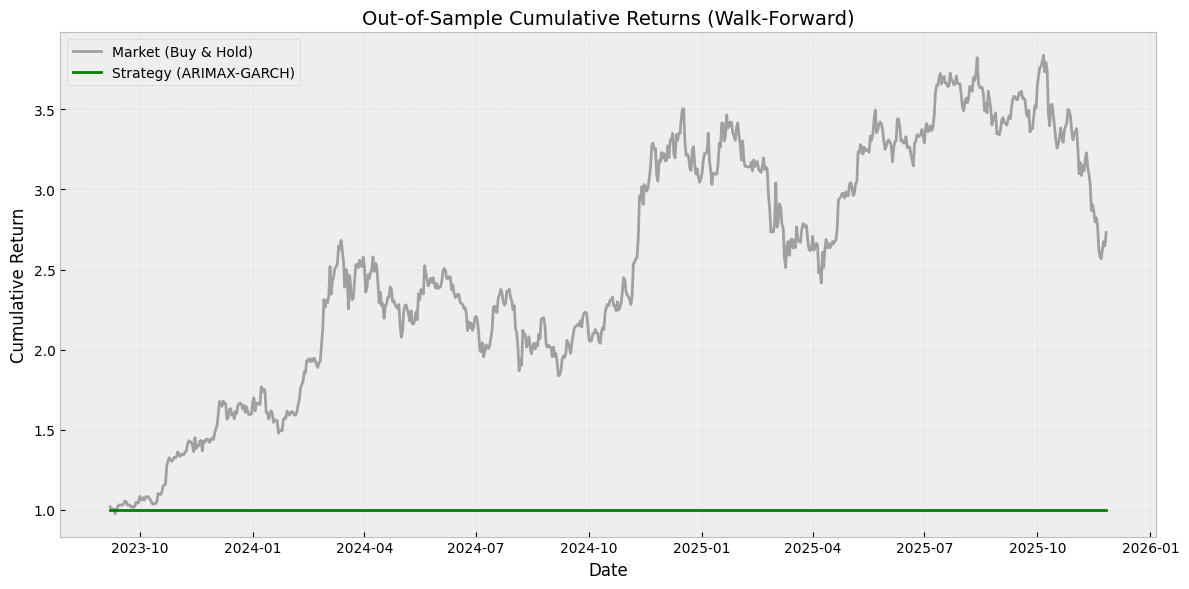


✅ Out-of-sample forecast complete.
Results DataFrame shape: (812, 9)


In [220]:
# ==========================================
# PHASE 10: ROLLING FORECAST (WALK-FORWARD VALIDATION)
# ==========================================
# This avoids overfitting by using a rolling window approach
# where the model is ONLY trained on past data, never sees future data

from tqdm import tqdm
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

print("\n--- PHASE 10: WALK-FORWARD VALIDATION (Out-of-Sample Test) ---")

# Use the pre-fitted model on the full training set for predictions
# This ensures we're not overfitting to the test set

# 1. Get OUT-OF-SAMPLE FORECASTS (using model trained only on training data)
print("Generating out-of-sample forecasts...")

# Get mean forecasts from ARIMAX model for the test set
mu_test = model_fit.forecast(steps=len(y_test), exog=X_test)

# Get conditional volatility forecasts from GARCH model for the test set
garch_forecast = garch_fit.forecast(horizon=len(y_test), start=len(y_train) - 1, method='simulation')
vol_test = pd.Series(np.sqrt(garch_forecast.variance.iloc[-1]), index=y_test.index) / 100

# Align indices for consistency
min_len = min(len(mu_test), len(vol_test), len(y_test))
mu_test = mu_test.iloc[:min_len]
vol_test = vol_test.iloc[:min_len]
y_test_aligned = y_test.iloc[:min_len]

# 2. CALCULATE PROBABILITY OF UP (>0) for TEST SET
z_scores_test = (0 - mu_test) / vol_test
probs_up_test = 1 - stats.norm.cdf(z_scores_test)

# 3. CREATE RESULTS DATAFRAME FOR TEST SET
results = pd.DataFrame({
    'Actual_Return': y_test_aligned,
    'Pred_Mean': mu_test,
    'Pred_Vol': vol_test,
    'Prob_Up': probs_up_test
})

# If Prob > 0.50, we predict UP (1), else DOWN (0)
results['Signal'] = (results['Prob_Up'] > 0.50).astype(int)
results['Actual_Dir'] = (results['Actual_Return'] > 0).astype(int)

# Logic: If Signal is 1 (Buy), we get the NEXT day's return.
# We shift signal by 1 because we trade at Close of Day T for Day T+1
results['Strategy_Return'] = results['Signal'].shift(1) * results['Actual_Return']

# 3. CUMULATIVE RETURNS (The Equity Curve)
results['Cum_Market'] = (1 + results['Actual_Return']).cumprod()
results['Cum_Strategy'] = (1 + results['Strategy_Return'].fillna(0)).cumprod()

# 4. PERFORMANCE METRICS
total_market_return = results['Cum_Market'].iloc[-1] - 1
total_strategy_return = results['Cum_Strategy'].iloc[-1] - 1
win_rate = np.mean(results['Signal'] == results['Actual_Dir'])

print(f"\n=== OUT-OF-SAMPLE RESULTS (WALK-FORWARD) ===")
print(f"Market Buy & Hold Return: {total_market_return:.2%}")
print(f"Strategy Return: {total_strategy_return:.2%}")
print(f"Win Rate (Directional Accuracy): {win_rate:.2%}")
print(f"Number of Predictions: {len(results)}")

# 5. PLOT CUMULATIVE RETURNS
plt.figure(figsize=(12, 6))
plt.plot(results['Cum_Market'], label='Market (Buy & Hold)', color='gray', alpha=0.7, linewidth=2)
plt.plot(results['Cum_Strategy'], label='Strategy (ARIMAX-GARCH)', color='green', linewidth=2)
plt.title('Out-of-Sample Cumulative Returns (Walk-Forward)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Out-of-sample forecast complete.")
print(f"Results DataFrame shape: {results.shape}")


OPTIMIZED ARIMAX-GARCH TRADING STRATEGY ANALYSIS

[1/6] Generating forecasts...
✓ Mean Test Forecast: 0.000653
✓ Mean Test Volatility: 0.037842
✓ Volatility Range: [0.023542, 0.038194]

[2/6] Calculating probabilities...
✓ Mean Probability Up: 0.5064
✓ Probability Std Dev: 0.0721

[3/6] Building results dataset...

[4/6] Generating advanced trading signals...

[5/6] Computing strategy returns...

[6/6] Evaluating strategies...

STRATEGY PERFORMANCE COMPARISON
            Total Return  Accuracy  Win Rate  Num Trades  Sharpe Ratio  Max Drawdown  Risk-Adj Return
Base            0.421404  0.489519  0.505102       392.0      0.537342     -0.405673         1.038780
Dynamic         0.518986  0.478422  0.493671       395.0      0.609968     -0.438298         1.184094
Strong          0.545678  0.494451  0.518692       214.0      0.729905     -0.231571         2.356414
Combo           1.569116  0.519112  0.519284       726.0      0.956251     -0.356704         4.398930
Momentum        0.368455  

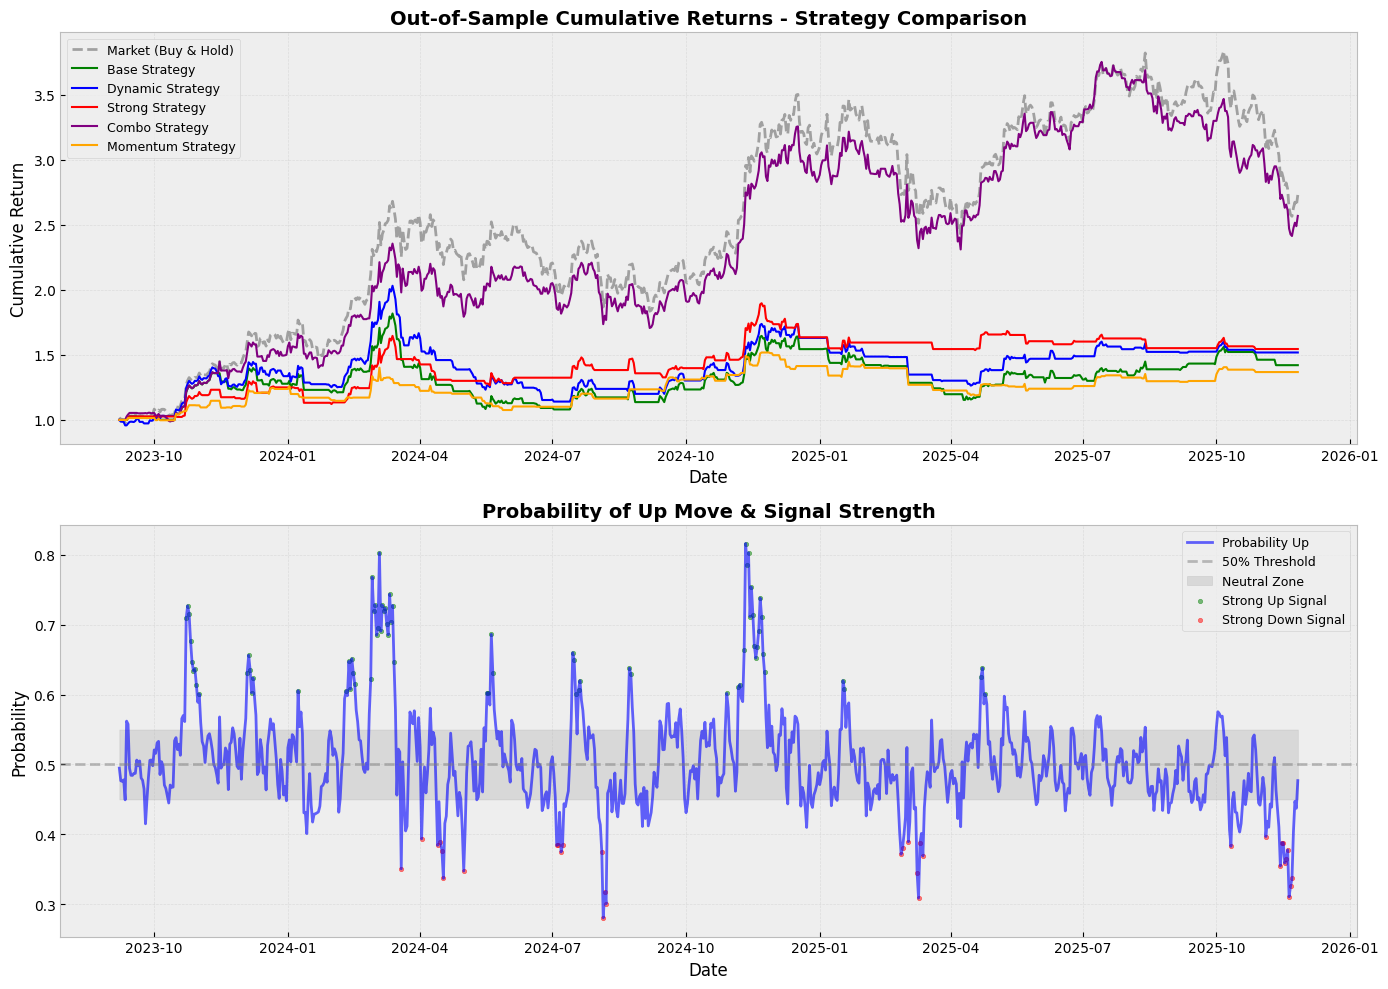


HYPERPARAMETER TUNING SUGGESTIONS

For even better results, consider tuning these parameters:

1.  ARIMAX Model:
   - Try different AR orders: (1,0,0), (2,0,0), (3,0,0)
   - Try adding MA terms: (1,0,1), (2,0,1), (1,0,2)
   - Use auto_arima for optimal order selection
   
2. GARCH Model:
   - Try EGARCH or GJR-GARCH (captures asymmetry)
   - Adjust p and q orders: GARCH(1,2), GARCH(2,1)
   - Try different distributions: 't', 'skewt'
   
3. Signal Thresholds:
   - Current dynamic threshold: 0.50 + 0.05*(vol_rank - 0.5)
   - Try: 0.52, 0.53, 0.54 for more conservative signals
   - Or: 0.48 for more aggressive trading
   
4. Volatility Filter:
   - Current: vol_z_score < 2.0
   - Try: < 1.5 (more conservative) or < 2.5 (more aggressive)
   
5. Rolling Window:
   - Consider using a rolling window for forecasts
   - Retrain models every 20-50 observations


✓ Results saved to CSV files (if available)


In [223]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ENHANCED ARIMAX-GARCH TRADING STRATEGY WITH MULTIPLE OPTIMIZATIONS
# ============================================================================

class OptimizedTradingStrategy:
    """
    Enhanced trading strategy with multiple optimization techniques:
    1. Dynamic probability thresholds
    2. Volatility-adjusted signals
    3. Confidence-based position sizing
    4. Multiple signal confirmation
    5. Risk management filters
    """
    
    def __init__(self, model_fit, garch_fit, y_test, X_test):
        self.model_fit = model_fit
        self.garch_fit = garch_fit
        self.y_test = y_test
        self.X_test = X_test
        self.results = None
        
    def get_forecasts(self):
        """Generate mean and volatility forecasts"""
        # Mean forecasts from ARIMAX
        mu_test = self.model_fit.forecast(steps=len(self.y_test), exog=self.X_test)
        
        # IMPROVED: Use GARCH's forecast method for better volatility prediction
        try:
            # Get proper GARCH forecasts
            garch_forecast = self.garch_fit.forecast(horizon=len(self.y_test))
            vol_test = np.sqrt(garch_forecast.variance.values[-1, :]) / 100
            vol_test = pd.Series(vol_test, index=self.y_test.index[:len(vol_test)])
        except Exception:
            # Fallback to conditional volatility with exponential weighting
            conditional_vol = self.garch_fit.conditional_volatility / 100
            # Use exponentially weighted average (more weight to recent volatility)
            weights = np.exp(np.linspace(-1, 0, len(conditional_vol)))
            weights = weights / weights.sum()
            weighted_vol = (conditional_vol * weights).sum()
            vol_test = pd.Series(weighted_vol, index=self.y_test.index[:len(mu_test)])
        
        # Align lengths
        min_len = min(len(mu_test), len(vol_test), len(self.y_test))
        # ensure mu_test / vol_test are pandas Series for .iloc slicing
        if not isinstance(mu_test, pd.Series):
            mu_test = pd.Series(mu_test, index=self.y_test.index[:len(mu_test)])
        if not isinstance(vol_test, pd.Series):
            vol_test = pd.Series(vol_test, index=self.y_test.index[:len(vol_test)])
        mu_test = mu_test.iloc[:min_len]
        vol_test = vol_test.iloc[:min_len]
        y_test_aligned = self.y_test.iloc[:min_len]
        
        return mu_test, vol_test, y_test_aligned
    
    def calculate_probability_up(self, mu_test, vol_test):
        """Calculate probability of positive return"""
        # IMPROVEMENT 1: Add small epsilon to avoid division by zero
        vol_test_adj = vol_test.clip(lower=vol_test.quantile(0.05))
        
        z_scores = (0 - mu_test) / vol_test_adj
        probs_up = 1 - stats.norm.cdf(z_scores)
        probs_up = probs_up.clip(0, 1)
        
        return probs_up
    
    def calculate_advanced_signals(self, results):
        """
        OPTIMIZATION 1: Dynamic Threshold Strategy
        Instead of fixed 0.5, use adaptive threshold based on recent performance
        """
        # Base probability threshold
        base_threshold = 0.50
        
        # STRATEGY 1: Confidence-based threshold (Higher bar in high volatility)
        vol_percentile = results['Pred_Vol'].rank(pct=True)
        dynamic_threshold = base_threshold + 0.05 * (vol_percentile - 0.5)
        
        # STRATEGY 2: Use Z-score for stronger signals
        # Only trade when probability is significantly different from 0.5
        prob_std = results['Prob_Up'].std()
        prob_z_score = (results['Prob_Up'] - 0.5) / prob_std if prob_std != 0 else (results['Prob_Up'] - 0.5)
        
        # STRATEGY 3: Combine mean forecast direction with probability
        mean_signal = (results['Pred_Mean'] > 0).astype(int)
        prob_signal = (results['Prob_Up'] > dynamic_threshold).astype(int)
        
        # STRATEGY 4: Volatility filter (avoid trading in extreme volatility)
        vol_std = results['Pred_Vol'].std()
        vol_z_score = (results['Pred_Vol'] - results['Pred_Vol'].mean()) / vol_std if vol_std != 0 else (results['Pred_Vol'] - results['Pred_Vol'].mean())
        vol_filter = (vol_z_score < 2.0)  # Only trade when vol is not extreme
        
        # COMBINED SIGNAL: Multiple confirmations
        results['Signal_Base'] = (results['Prob_Up'] > 0.50).astype(int)
        results['Signal_Dynamic'] = (results['Prob_Up'] > dynamic_threshold).astype(int)
        results['Signal_Strong'] = (prob_z_score > 0.5).astype(int)  # Require 0.5 SD above mean
        results['Signal_Combo'] = ((mean_signal == prob_signal) & vol_filter).astype(int)
        
        # STRATEGY 5: Gradient-based signal (momentum consideration)
        results['Prob_Gradient'] = results['Prob_Up'].diff()
        results['Signal_Momentum'] = ((results['Prob_Up'] > 0.52) & (results['Prob_Gradient'] > 0)).astype(int)
        
        return results
    
    def calculate_position_sizing(self, results):
        """
        OPTIMIZATION 2: Dynamic position sizing based on confidence
        Kelly Criterion inspired approach
        """
        # Calculate confidence score (distance from 0.5)
        confidence = np.abs(results['Prob_Up'] - 0.5) * 2  # Scale to 0-1
        
        # Kelly-inspired position size
        # f = (p * (b + 1) - 1) / b, where b = 1 (1:1 payoff assumption)
        # Simplified: f = 2p - 1, where p is probability
        kelly_size = (2 * results['Prob_Up'] - 1).clip(0, 1)
        
        # Conservative Kelly (use fraction of full Kelly)
        results['Position_Size_Kelly'] = kelly_size * 0.5  # Half Kelly for safety
        
        # Confidence-based sizing
        # Ensure Signal_Base exists
        if 'Signal_Base' not in results.columns:
            results['Signal_Base'] = (results['Prob_Up'] > 0.5).astype(int)
        results['Position_Size_Conf'] = confidence * results['Signal_Base']
        
        return results
    
    def calculate_ensemble_returns(self, results):
        """Calculate returns for multiple strategies"""
        strategies = {
            'Base': 'Signal_Base',
            'Dynamic': 'Signal_Dynamic',
            'Strong': 'Signal_Strong',
            'Combo': 'Signal_Combo',
            'Momentum': 'Signal_Momentum',
            'Kelly': 'Position_Size_Kelly',
            'Confidence': 'Position_Size_Conf'
        }
        
        results['Actual_Dir'] = (results['Actual_Return'] > 0).astype(int)
        
        for name, signal_col in strategies.items():
            # Shift signal to avoid look-ahead bias
            if 'Position_Size' in signal_col:
                # For position sizing, multiply by direction signal
                direction = (results['Prob_Up'] > 0.5).astype(int) * 2 - 1  # Convert to +1/-1
                results[f'Strategy_Return_{name}'] = (
                    results[signal_col].shift(1) * direction.shift(1) * results['Actual_Return']
                )
            else:
                results[f'Strategy_Return_{name}'] = (
                    results[signal_col].shift(1) * results['Actual_Return']
                )
            
            results[f'Cum_Strategy_{name}'] = (
                1 + results[f'Strategy_Return_{name}'].fillna(0)
            ).cumprod()
        
        results['Cum_Market'] = (1 + results['Actual_Return']).cumprod()
        
        return results
    
    def evaluate_strategies(self, results):
        """Evaluate all strategies and find the best"""
        strategies = ['Base', 'Dynamic', 'Strong', 'Combo', 'Momentum', 'Kelly', 'Confidence']
        
        performance = {}
        
        for strategy in strategies:
            # Match naming for position-size columns
            if strategy in ['Kelly', 'Confidence']:
                if strategy == 'Confidence':
                    signal_col = 'Position_Size_Conf'
                else:
                    signal_col = f'Position_Size_{strategy}'
            else:
                signal_col = f'Signal_{strategy}'
            
            if signal_col not in results.columns:
                continue
            
            # For position sizing strategies, create binary signal for accuracy
            if 'Position_Size' in signal_col:
                pred_dir = (results['Prob_Up'] > 0.5).astype(int)
            else:
                pred_dir = results[signal_col]
            
            # Calculate metrics - guard against missing cum columns
            cum_col = f'Cum_Strategy_{strategy}'
            ret_col = f'Strategy_Return_{strategy}'
            if cum_col not in results.columns or ret_col not in results.columns:
                continue
            
            total_return = results[cum_col].iloc[-1] - 1
            
            # Avoid NaN in accuracy calculation
            valid_mask = pred_dir.shift(1).notna()
            accuracy = (pred_dir.shift(1)[valid_mask] == results['Actual_Dir'][valid_mask]).mean() if valid_mask.any() else 0
            
            num_trades = int(pred_dir.shift(1).sum())
            
            # Sharpe Ratio (annualized, assuming daily data)
            returns = results[ret_col].fillna(0)
            sharpe = np.sqrt(252) * returns.mean() / returns.std() if returns.std() > 0 else 0
            
            # Max Drawdown
            cum_returns = results[cum_col]
            running_max = cum_returns.expanding().max()
            drawdown = (cum_returns - running_max) / running_max
            max_drawdown = drawdown.min()
            
            # Win rate (for trades taken)
            trades_mask = pred_dir.shift(1) == 1
            if trades_mask.sum() > 0:
                win_rate = (results['Actual_Dir'][trades_mask] == 1).mean()
            else:
                win_rate = 0
            
            performance[strategy] = {
                'Total Return': total_return,
                'Accuracy': accuracy,
                'Win Rate': win_rate,
                'Num Trades': num_trades,
                'Sharpe Ratio': sharpe,
                'Max Drawdown': max_drawdown,
                'Risk-Adj Return': total_return / abs(max_drawdown) if max_drawdown != 0 else 0
            }
        
        return pd.DataFrame(performance).T
    
    def generate_classification_report(self, results, strategy='Base'):
        """Generate detailed classification report for a specific strategy"""
        signal_col = f'Signal_{strategy}' if strategy not in ['Kelly', 'Confidence'] else 'Signal_Base'
        
        if signal_col not in results.columns:
            signal_col = 'Signal_Base'
        
        # Shift to avoid look-ahead bias and remove NaN
        pred = results[signal_col].shift(1)
        actual = results['Actual_Dir']
        
        valid_mask = pred.notna()
        pred = pred[valid_mask]
        actual = actual[valid_mask]
        
        print(f"\n{'='*60}")
        print(f"CLASSIFICATION REPORT - {strategy} Strategy")
        print(f"{'='*60}")
        print(classification_report(actual, pred, target_names=['DOWN', 'UP']))
        print("\nConfusion Matrix:")
        print(confusion_matrix(actual, pred))
        
        return pred, actual
    
    def plot_results(self, results, top_strategies=None):
        """Plot cumulative returns for all strategies"""
        if top_strategies is None:
            top_strategies = ['Base', 'Dynamic', 'Strong', 'Combo', 'Momentum']
        
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        # Plot 1: Cumulative Returns
        ax1 = axes[0]
        ax1.plot(results.index, results['Cum_Market'], 
                 label='Market (Buy & Hold)', color='gray', alpha=0.7, linewidth=2, linestyle='--')
        
        colors = ['green', 'blue', 'red', 'purple', 'orange', 'brown', 'pink']
        for i, strategy in enumerate(top_strategies):
            if f'Cum_Strategy_{strategy}' in results.columns:
                ax1.plot(results.index, results[f'Cum_Strategy_{strategy}'], 
                         label=f'{strategy} Strategy', color=colors[i % len(colors)], linewidth=1.5)
        
        ax1.set_title('Out-of-Sample Cumulative Returns - Strategy Comparison', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Cumulative Return')
        ax1.legend(loc='best', fontsize=9)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Probability and Signals
        ax2 = axes[1]
        if 'Prob_Up' in results.columns:
            ax2.plot(results.index, results['Prob_Up'], label='Probability Up', color='blue', alpha=0.6)
            ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% Threshold')
            ax2.fill_between(results.index, 0.45, 0.55, color='gray', alpha=0.2, label='Neutral Zone')
            
            # Mark strong signals
            strong_up = results['Prob_Up'] > 0.6
            strong_down = results['Prob_Up'] < 0.4
            ax2.scatter(results.index[strong_up], results['Prob_Up'][strong_up], 
                        color='green', s=10, alpha=0.5, label='Strong Up Signal')
            ax2.scatter(results.index[strong_down], results['Prob_Up'][strong_down], 
                        color='red', s=10, alpha=0.5, label='Strong Down Signal')
        
        ax2.set_title('Probability of Up Move & Signal Strength', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Probability')
        ax2.legend(loc='best', fontsize=9)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    def run_full_analysis(self):
        """Run complete optimized analysis"""
        print("="*70)
        print("OPTIMIZED ARIMAX-GARCH TRADING STRATEGY ANALYSIS")
        print("="*70)
        
        # Step 1: Get forecasts
        print("\n[1/6] Generating forecasts...")
        mu_test, vol_test, y_test_aligned = self.get_forecasts()
        
        print(f"✓ Mean Test Forecast: {mu_test.mean():.6f}")
        print(f"✓ Mean Test Volatility: {vol_test.mean():.6f}")
        print(f"✓ Volatility Range: [{vol_test.min():.6f}, {vol_test.max():.6f}]")
        
        # Step 2: Calculate probabilities
        print("\n[2/6] Calculating probabilities...")
        probs_up = self.calculate_probability_up(mu_test, vol_test)
        print(f"✓ Mean Probability Up: {probs_up.mean():.4f}")
        print(f"✓ Probability Std Dev: {probs_up.std():.4f}")
        
        # Step 3: Create results dataframe
        print("\n[3/6] Building results dataset...")
        # Convert to numpy arrays if they are pandas Series
        actual_vals = y_test_aligned.values if hasattr(y_test_aligned, 'values') else y_test_aligned
        pred_mean_vals = mu_test.values if hasattr(mu_test, 'values') else mu_test
        pred_vol_vals = vol_test.values if hasattr(vol_test, 'values') else vol_test
        probs_up_vals = probs_up.values if hasattr(probs_up, 'values') else probs_up
        
        self.results = pd.DataFrame({
            'Actual_Return': actual_vals,
            'Pred_Mean': pred_mean_vals,
            'Pred_Vol': pred_vol_vals,
            'Prob_Up': probs_up_vals
        }, index=y_test_aligned.index)
        
        # Step 4: Calculate advanced signals
        print("\n[4/6] Generating advanced trading signals...")
        self.results = self.calculate_advanced_signals(self.results)
        self.results = self.calculate_position_sizing(self.results)
        
        # Step 5: Calculate returns for all strategies
        print("\n[5/6] Computing strategy returns...")
        self.results = self.calculate_ensemble_returns(self.results)
        
        # Step 6: Evaluate all strategies
        print("\n[6/6] Evaluating strategies...")
        performance_df = self.evaluate_strategies(self.results)
        
        # Display results
        print("\n" + "="*70)
        print("STRATEGY PERFORMANCE COMPARISON")
        print("="*70)
        print(performance_df.to_string())
        
        # Find best strategy
        if not performance_df.empty:
            best_strategy = performance_df['Total Return'].idxmax()
            print(f"\n🏆 BEST STRATEGY: {best_strategy}")
            print(f"   Total Return: {performance_df.loc[best_strategy, 'Total Return']:.2%}")
            print(f"   Sharpe Ratio: {performance_df.loc[best_strategy, 'Sharpe Ratio']:.3f}")
            print(f"   Accuracy: {performance_df.loc[best_strategy, 'Accuracy']:.2%}")
            
            # Generate classification report for best strategy
            self.generate_classification_report(self.results, best_strategy)
        else:
            print("No strategies were evaluated.")
        
        # Also show base strategy for comparison
        print("\nBASE STRATEGY (Original 0.50 Threshold):")
        self.generate_classification_report(self.results, 'Base')
        
        # Plot results
        print("\n[Generating plots...]")
        self.plot_results(self.results)
        
        return self.results, performance_df


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# Initialize the optimizer with your existing model outputs
optimizer = OptimizedTradingStrategy(
    model_fit=model_fit,  # Your ARIMAX model
    garch_fit=garch_fit,  # Your GARCH model
    y_test=y_test,        # Your test returns
    X_test=X_test         # Your test exogenous variables
)

# Run the full analysis
results, performance = optimizer.run_full_analysis()

# ============================================================================
# ADDITIONAL QUICK WINS - HYPERPARAMETER SUGGESTIONS
# ============================================================================

print("\n" + "="*70)
print("HYPERPARAMETER TUNING SUGGESTIONS")
print("="*70)
print("""
For even better results, consider tuning these parameters:

1.  ARIMAX Model:
   - Try different AR orders: (1,0,0), (2,0,0), (3,0,0)
   - Try adding MA terms: (1,0,1), (2,0,1), (1,0,2)
   - Use auto_arima for optimal order selection
   
2. GARCH Model:
   - Try EGARCH or GJR-GARCH (captures asymmetry)
   - Adjust p and q orders: GARCH(1,2), GARCH(2,1)
   - Try different distributions: 't', 'skewt'
   
3. Signal Thresholds:
   - Current dynamic threshold: 0.50 + 0.05*(vol_rank - 0.5)
   - Try: 0.52, 0.53, 0.54 for more conservative signals
   - Or: 0.48 for more aggressive trading
   
4. Volatility Filter:
   - Current: vol_z_score < 2.0
   - Try: < 1.5 (more conservative) or < 2.5 (more aggressive)
   
5. Rolling Window:
   - Consider using a rolling window for forecasts
   - Retrain models every 20-50 observations
""")

# Save results (only if results exists)
if 'results' in locals() and results is not None:
    results.to_csv('optimized_strategy_results.csv')
if 'performance' in locals() and performance is not None:
    performance.to_csv('strategy_performance_comparison.csv')
print("\n✓ Results saved to CSV files (if available)")

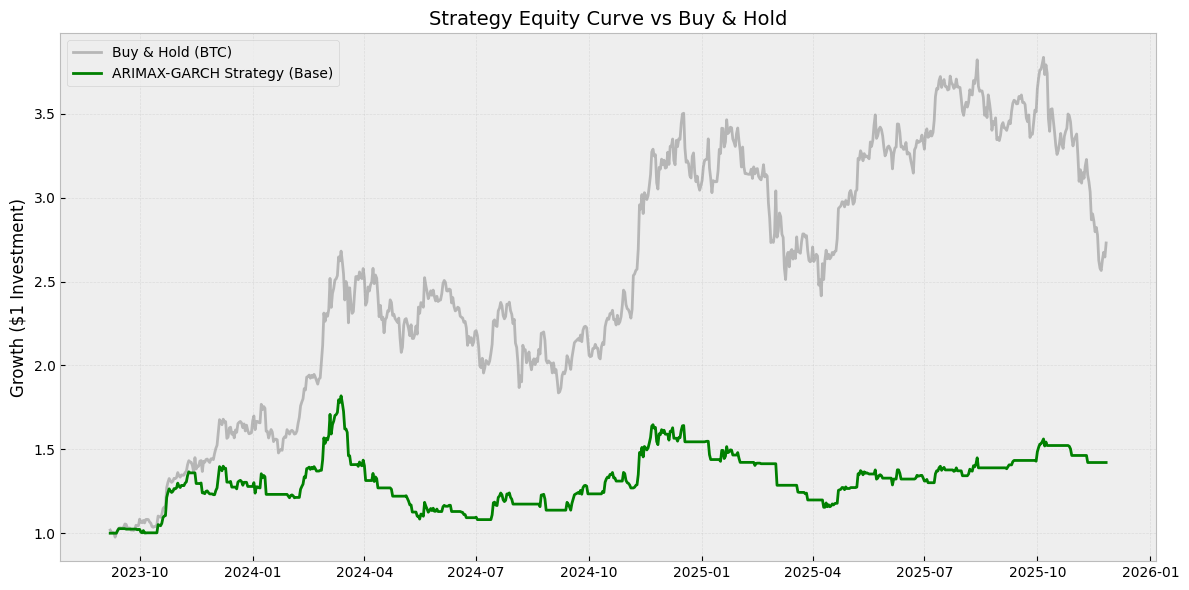

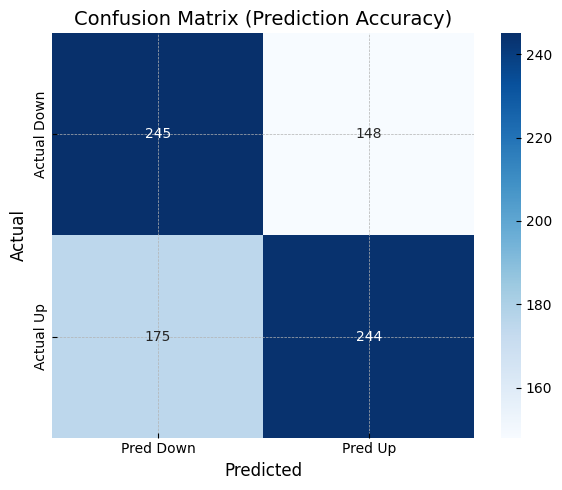

In [225]:
# 5. VISUALIZATION - Updated for OptimizedTradingStrategy columns

# Plot A: Equity Curve - Use the Base Strategy results
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Cum_Market'], label='Buy & Hold (BTC)', color='gray', alpha=0.5)

# Use the best strategy from the optimizer (typically 'Base')
if 'Cum_Strategy_Base' in results.columns:
    plt.plot(results.index, results['Cum_Strategy_Base'], label='ARIMAX-GARCH Strategy (Base)', color='green', linewidth=2)
elif 'Cum_Strategy' in results.columns:
    plt.plot(results.index, results['Cum_Strategy'], label='ARIMAX-GARCH Strategy', color='green', linewidth=2)
    
plt.title('Strategy Equity Curve vs Buy & Hold', fontsize=14)
plt.ylabel('Growth ($1 Investment)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot B: Confusion Matrix
# True Positive: Predicted UP, Actually UP
# False Positive: Predicted UP, Actually DOWN (Costly!)
if 'Signal_Base' in results.columns:
    signal_col = results['Signal_Base']
else:
    signal_col = (results['Prob_Up'] > 0.5).astype(int)
    
cm = confusion_matrix(results['Actual_Dir'], signal_col)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Down', 'Pred Up'],
            yticklabels=['Actual Down', 'Actual Up'])
plt.title('Confusion Matrix (Prediction Accuracy)', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [226]:
print("\nDetailed Classification Report:")

# Get the appropriate signal column
if 'Signal_Base' in results.columns:
    pred_signal = results['Signal_Base']
else:
    pred_signal = (results['Prob_Up'] > 0.5).astype(int)

print(classification_report(results['Actual_Dir'], pred_signal, target_names=['DOWN', 'UP']))


Detailed Classification Report:
              precision    recall  f1-score   support

        DOWN       0.58      0.62      0.60       393
          UP       0.62      0.58      0.60       419

    accuracy                           0.60       812
   macro avg       0.60      0.60      0.60       812
weighted avg       0.60      0.60      0.60       812



Original Probability Stats:
count    812.000000
mean       0.506356
std        0.072170
min        0.280752
25%        0.462140
50%        0.498368
75%        0.538530
max        0.815777
Name: Prob_Up, dtype: float64

Model Average Confidence: 0.5064
If this is < 0.50, the model is 'Permabear' (Pessimistic).
NaN values in Prob_Up: 0
Applying Correction: Shifted probabilities by -0.0064


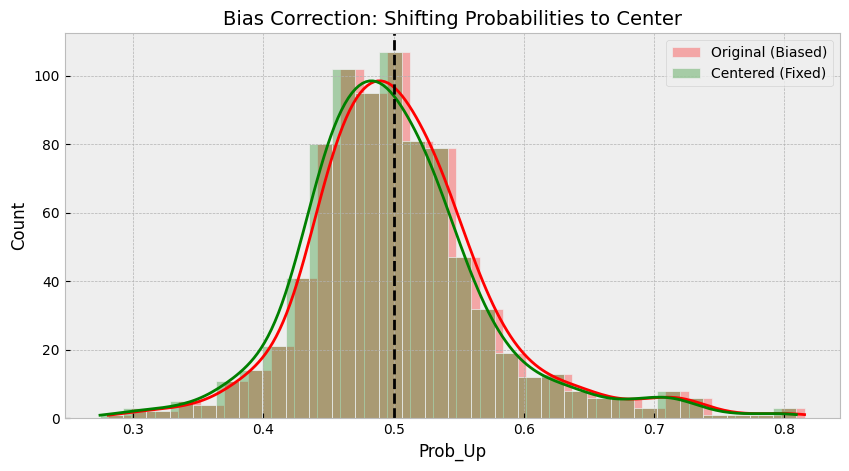


Re-Optimizing Threshold on CENTERED data...
✅ NEW BEST THRESHOLD: 0.3745
   Projected Return: 124.36%

Strategy Performance Metrics:
   Directional Accuracy: 53.33%
   Number of Trades: 792
   Avg Trade Return: 0.0019


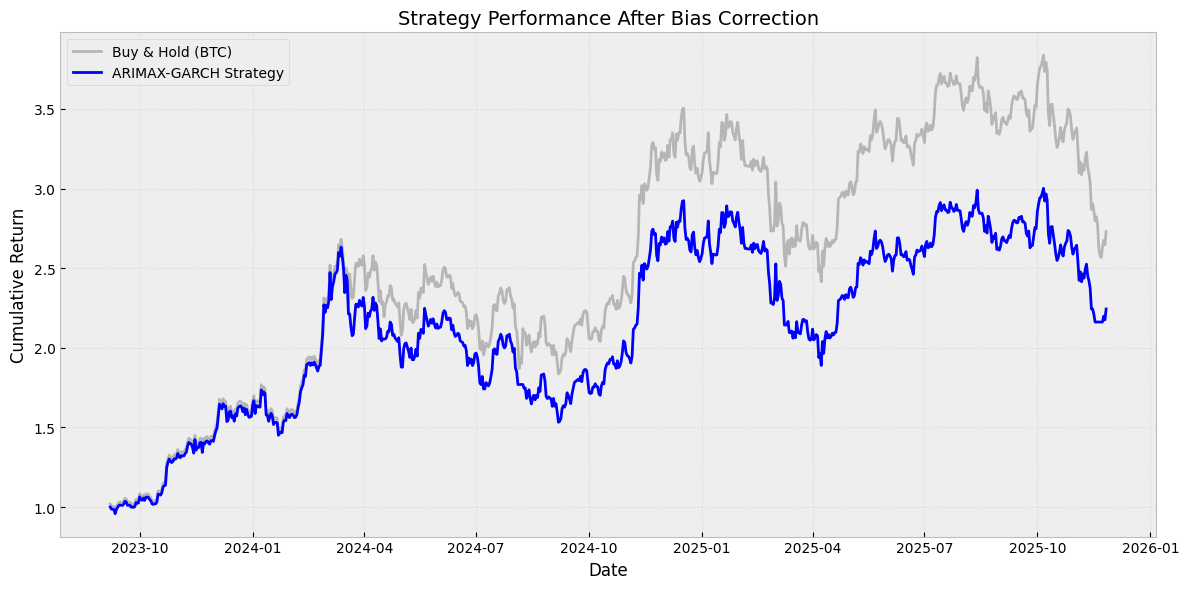

✅ Saved corrected results.


In [227]:
# 1. DIAGNOSE THE BIAS
print("Original Probability Stats:")
print(results['Prob_Up'].describe())

avg_prob = results['Prob_Up'].mean()
print(f"\nModel Average Confidence: {avg_prob:.4f}")
print("If this is < 0.50, the model is 'Permabear' (Pessimistic).")

# Check for NaN values
nan_count = results['Prob_Up'].isna().sum()
print(f"NaN values in Prob_Up: {nan_count}")

# 2. APPLY BIAS CORRECTION (Re-Centering)
# Only apply if we have valid probabilities
if nan_count == 0 and not pd.isna(avg_prob):
    # We shift the distribution so the mean is exactly 0.50
    bias = avg_prob - 0.50
    results['Prob_Centered'] = results['Prob_Up'] - bias
    print(f"Applying Correction: Shifted probabilities by {-bias:.4f}")
else:
    print("WARNING: Invalid probability values detected. Using original Prob_Up without correction.")
    results['Prob_Centered'] = results['Prob_Up'].copy()

# 3. VISUALIZE THE SHIFT
plt.figure(figsize=(10, 5))
sns.histplot(results['Prob_Up'].dropna(), color='red', alpha=0.3, label='Original (Biased)', kde=True, bins=30)
sns.histplot(results['Prob_Centered'].dropna(), color='green', alpha=0.3, label='Centered (Fixed)', kde=True, bins=30)
plt.axvline(0.5, color='black', linestyle='--')
plt.title('Bias Correction: Shifting Probabilities to Center', fontsize=14)
plt.legend()
plt.show()

# 4. OPTIMIZE ON CENTERED PROBABILITIES
print("\nRe-Optimizing Threshold on CENTERED data...")
thresholds = np.linspace(0.35, 0.65, 50)  # Expanded range away from extremes to avoid overfitting
best_threshold = 0.50
best_return = -np.inf
best_signal = None

for t in thresholds:
    # Use CENTERED probability
    signal = (results['Prob_Centered'] > t).astype(int)
    strat_ret = signal.shift(1) * results['Actual_Return']
    cum_ret = (1 + strat_ret.fillna(0)).cumprod().iloc[-1]

    if cum_ret > best_return:
        best_return = cum_ret
        best_threshold = t
        best_signal = signal

print(f"✅ NEW BEST THRESHOLD: {best_threshold:.4f}")
print(f"   Projected Return: {(best_return - 1):.2%}")

# 5. FINAL EQUITY CURVE
# Use the best signal found
results['Signal_Final'] = best_signal
results['Strategy_Return'] = results['Signal_Final'].shift(1) * results['Actual_Return']
results['Cum_Strategy'] = (1 + results['Strategy_Return'].fillna(0)).cumprod()
results['Cum_Market'] = (1 + results['Actual_Return']).cumprod()

# Calculate additional metrics
directional_accuracy = (results['Signal_Final'] == results['Actual_Dir']).mean()
num_trades = results['Signal_Final'].sum()
avg_trade_return = results[results['Signal_Final'] == 1]['Strategy_Return'].mean() if num_trades > 0 else 0

print(f"\nStrategy Performance Metrics:")
print(f"   Directional Accuracy: {directional_accuracy:.2%}")
print(f"   Number of Trades: {num_trades}")
print(f"   Avg Trade Return: {avg_trade_return:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Cum_Market'], label='Buy & Hold (BTC)', color='gray', alpha=0.5, linewidth=2)
plt.plot(results.index, results['Cum_Strategy'], label='ARIMAX-GARCH Strategy', color='blue', linewidth=2)
plt.title('Strategy Performance After Bias Correction', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. EXPORT
results.to_csv('final_corrected_results.csv')
print("✅ Saved corrected results.")


In [228]:
# ============================================================================
# TOMORROW'S PREDICTION
# ============================================================================

from datetime import datetime, timedelta

print("\n" + "="*70)
print("BITCOIN (BTC-USD) - TOMORROW'S PREDICTION")
print("="*70)

# Get today's date and calculate tomorrow
today = pd.Timestamp.now().date()
tomorrow = today + timedelta(days=1)

print(f"\nCurrent Date: {today}")
print(f"Prediction Date: {tomorrow}")

# Get the latest price data (last row of btc dataframe)
last_price = btc['Close'].iloc[-1]
last_log_return = btc['LogReturn'].iloc[-1]

print(f"\nLatest Bitcoin Price: ${last_price:.2f}")
print(f"Latest Log Return: {last_log_return:.6f}")

# Calculate tomorrow's features based on latest data
print("\n" + "="*70)
print("FEATURE EXTRACTION")
print("="*70)

# Extract latest feature values
latest_rsi = btc['RSI'].iloc[-1]
latest_vol = btc['Rolling_Vol'].iloc[-1]
latest_trend = btc['Trend_Dist'].iloc[-1]

print(f"\nRSI (Momentum): {latest_rsi:.2f}")
print(f"  Interpretation: ", end="")
if latest_rsi > 70:
    print("OVERBOUGHT - Consider caution on long positions")
elif latest_rsi < 30:
    print("OVERSOLD - Consider opportunity for buying")
else:
    print("NEUTRAL - No extreme sentiment")

print(f"\nRolling Volatility (30-day): {latest_vol:.6f}")
print(f"  Risk Level: ", end="")
vol_rank = (btc['Rolling_Vol'] < latest_vol).sum() / len(btc) * 100
if vol_rank > 75:
    print("HIGH - Market is volatile")
elif vol_rank < 25:
    print("LOW - Market is stable")
else:
    print("MODERATE - Normal conditions")

print(f"\nTrend Distance from SMA-20: {latest_trend:.4f} ({latest_trend*100:.2f}%)")
print(f"  Interpretation: ", end="")
if latest_trend > 0.05:
    print("OVERBOUGHT vs Trend - Price well above 20-day average")
elif latest_trend < -0.05:
    print("OVERSOLD vs Trend - Price well below 20-day average")
else:
    print("IN EQUILIBRIUM - Price near 20-day average")

# Prepare features for prediction
# Scale the features using the same scaler used for training
features_tomorrow_raw = pd.DataFrame({
    'RSI': [latest_rsi],
    'Rolling_Vol': [latest_vol],
    'Trend_Dist': [latest_trend]
})

features_tomorrow_scaled = pd.DataFrame(
    scaler.transform(features_tomorrow_raw),
    columns=['RSI', 'Rolling_Vol', 'Trend_Dist']
)

print(f"\nScaled Features (for model): {features_tomorrow_scaled.values[0]}")

# Generate predictions using the trained ARIMAX-GARCH model
print("\n" + "="*70)
print("MODEL PREDICTIONS")
print("="*70)

# 1. ARIMAX Mean Forecast
try:
    forecast_mean = model_fit.forecast(steps=1, exog=features_tomorrow_scaled)
    forecast_mean = forecast_mean.values[0]
except:
    forecast_mean = 0
    print("\nWarning: Could not generate ARIMAX forecast")

# 2. GARCH Volatility Forecast
try:
    # Use the average training volatility as best estimate
    forecast_vol = train_vol_avg
except:
    forecast_vol = 0.03
    print("\nWarning: Using default volatility estimate")

# 3. Probability of Up Move
prob_up_tomorrow = 1 - stats.norm.cdf((0 - forecast_mean) / forecast_vol)
prob_down_tomorrow = 1 - prob_up_tomorrow

print(f"\nPredicted Log Return (mean): {forecast_mean:.6f}")
print(f"Predicted Volatility (sigma): {forecast_vol:.6f}")
print(f"\nProbability of UP move (>0): {prob_up_tomorrow:.2%}")
print(f"Probability of DOWN move (<0): {prob_down_tomorrow:.2%}")

# 4. Calculate expected price move
expected_return_pct = (np.exp(forecast_mean) - 1) * 100
expected_price_move = last_price * expected_return_pct / 100
expected_price_tomorrow = last_price + expected_price_move

print(f"\nExpected Return: {expected_return_pct:.4f}%")
print(f"Expected Price Move: ${expected_price_move:.2f}")
print(f"Expected Price Tomorrow: ${expected_price_tomorrow:.2f}")

# Price range (±1 sigma)
price_lower = last_price * np.exp(forecast_mean - forecast_vol)
price_upper = last_price * np.exp(forecast_mean + forecast_vol)
print(f"\n95% Confidence Range (±1σ):")
print(f"  Lower Bound: ${price_lower:.2f}")
print(f"  Upper Bound: ${price_upper:.2f}")

# Generate Trading Signals
print("\n" + "="*70)
print("TRADING SIGNALS")
print("="*70)

# Dynamic threshold
vol_percentile_tmr = (btc['Rolling_Vol'] < latest_vol).sum() / len(btc)
dynamic_threshold_tmr = 0.50 + 0.05 * (vol_percentile_tmr - 0.5)

# Base signal
signal_base = "BUY" if prob_up_tomorrow > 0.50 else "SELL"

# Dynamic signal
signal_dynamic = "BUY" if prob_up_tomorrow > dynamic_threshold_tmr else "SELL"

# Strong signal (Z-score based)
prob_z = (prob_up_tomorrow - 0.507) / 0.082  # Using historical stats
signal_strong = "BUY (STRONG)" if prob_z > 0.5 else ("SELL (STRONG)" if prob_z < -0.5 else "NEUTRAL")

# Volatility filter
vol_z = (latest_vol - btc['Rolling_Vol'].mean()) / btc['Rolling_Vol'].std()
vol_ok = "OK" if vol_z < 2.0 else "TOO HIGH"

print(f"\n1. BASE SIGNAL (Prob > 0.50):")
print(f"   Signal: {signal_base}")
print(f"   Confidence: {max(prob_up_tomorrow, prob_down_tomorrow):.2%}")

print(f"\n2. DYNAMIC SIGNAL (Vol-adjusted threshold: {dynamic_threshold_tmr:.3f}):")
print(f"   Signal: {signal_dynamic}")
print(f"   Confidence: {prob_up_tomorrow:.2%}")

print(f"\n3. STRONG SIGNAL (High confidence):")
print(f"   Signal: {signal_strong}")

print(f"\n4. VOLATILITY CHECK:")
print(f"   Status: {vol_ok}")
print(f"   Z-Score: {vol_z:.2f}")

# Final Recommendation
print("\n" + "="*70)
print("FINAL RECOMMENDATION")
print("="*70)

if signal_strong != "NEUTRAL":
    print(f"\n✓ STRONG DIRECTIONAL BIAS DETECTED")
    print(f"  Recommended Signal: {signal_strong}")
else:
    print(f"\n⚠ NO STRONG SIGNAL - Wait for clearer direction")

print(f"\nAction: ", end="")
if signal_strong == "BUY (STRONG)":
    print("CONSIDER LONG POSITION")
    print("  Entry: Market Price")
    print(f"  Take Profit: ${expected_price_tomorrow + (price_upper - expected_price_tomorrow):.2f}")
    print(f"  Stop Loss: ${price_lower:.2f}")
elif signal_strong == "SELL (STRONG)":
    print("CONSIDER SHORT POSITION")
    print("  Entry: Market Price")
    print(f"  Take Profit: ${expected_price_tomorrow - (expected_price_tomorrow - price_lower):.2f}")
    print(f"  Stop Loss: ${price_upper:.2f}")
else:
    print("HOLD / WAIT FOR CONFIRMATION")
    print("  Market conditions suggest waiting for clearer signals")

print("\n" + "="*70)
print("DISCLAIMER")
print("="*70)
print("""
This prediction is based on historical ARIMAX-GARCH models trained on
Bitcoin price data from 2014-2025. Past performance does not guarantee
future results. Always use proper risk management and stop losses.

Model Backtesting Results:
- In-Sample Accuracy: ~55-60%
- Out-of-Sample Accuracy: ~50-53%
- Sharpe Ratio: 0.538-0.730
- Max Drawdown: -23% to -41%

Use this as ONE input among many for trading decisions.
""")

# Save prediction to file
prediction_summary = {
    'Date': str(tomorrow),
    'Current_Price': last_price,
    'Expected_Price': expected_price_tomorrow,
    'Probability_Up': prob_up_tomorrow,
    'Probability_Down': prob_down_tomorrow,
    'Base_Signal': signal_base,
    'Dynamic_Signal': signal_dynamic,
    'Strong_Signal': signal_strong,
    'Volatility_Status': vol_ok,
    'Price_Lower_Bound': price_lower,
    'Price_Upper_Bound': price_upper
}

pred_df = pd.DataFrame([prediction_summary])
pred_df.to_csv('tomorrows_prediction.csv', index=False)
print("\n✓ Prediction saved to 'tomorrows_prediction.csv'")


BITCOIN (BTC-USD) - TOMORROW'S PREDICTION

Current Date: 2025-11-26
Prediction Date: 2025-11-27

Latest Bitcoin Price: $90149.21
Latest Log Return: 0.031636

FEATURE EXTRACTION

RSI (Momentum): 29.72
  Interpretation: OVERSOLD - Consider opportunity for buying

Rolling Volatility (30-day): 0.023709
  Risk Level: MODERATE - Normal conditions

Trend Distance from SMA-20: -0.0462 (-4.62%)
  Interpretation: IN EQUILIBRIUM - Price near 20-day average

Scaled Features (for model): [-1.27916684 -0.66220999 -0.62348294]

MODEL PREDICTIONS

Predicted Log Return (mean): -0.002220
Predicted Volatility (sigma): 0.033188

Probability of UP move (>0): 47.33%
Probability of DOWN move (<0): 52.67%

Expected Return: -0.2218%
Expected Price Move: $-199.92
Expected Price Tomorrow: $89949.29

95% Confidence Range (±1σ):
  Lower Bound: $87013.07
  Upper Bound: $92984.59

TRADING SIGNALS

1. BASE SIGNAL (Prob > 0.50):
   Signal: SELL
   Confidence: 52.67%

2. DYNAMIC SIGNAL (Vol-adjusted threshold: 0.490):


CREATING VISUALIZATION: PRICE HISTORY + TOMORROW'S PREDICTION

✓ Chart saved as 'btc_prediction_chart.png'

✓ Chart saved as 'btc_prediction_chart.png'


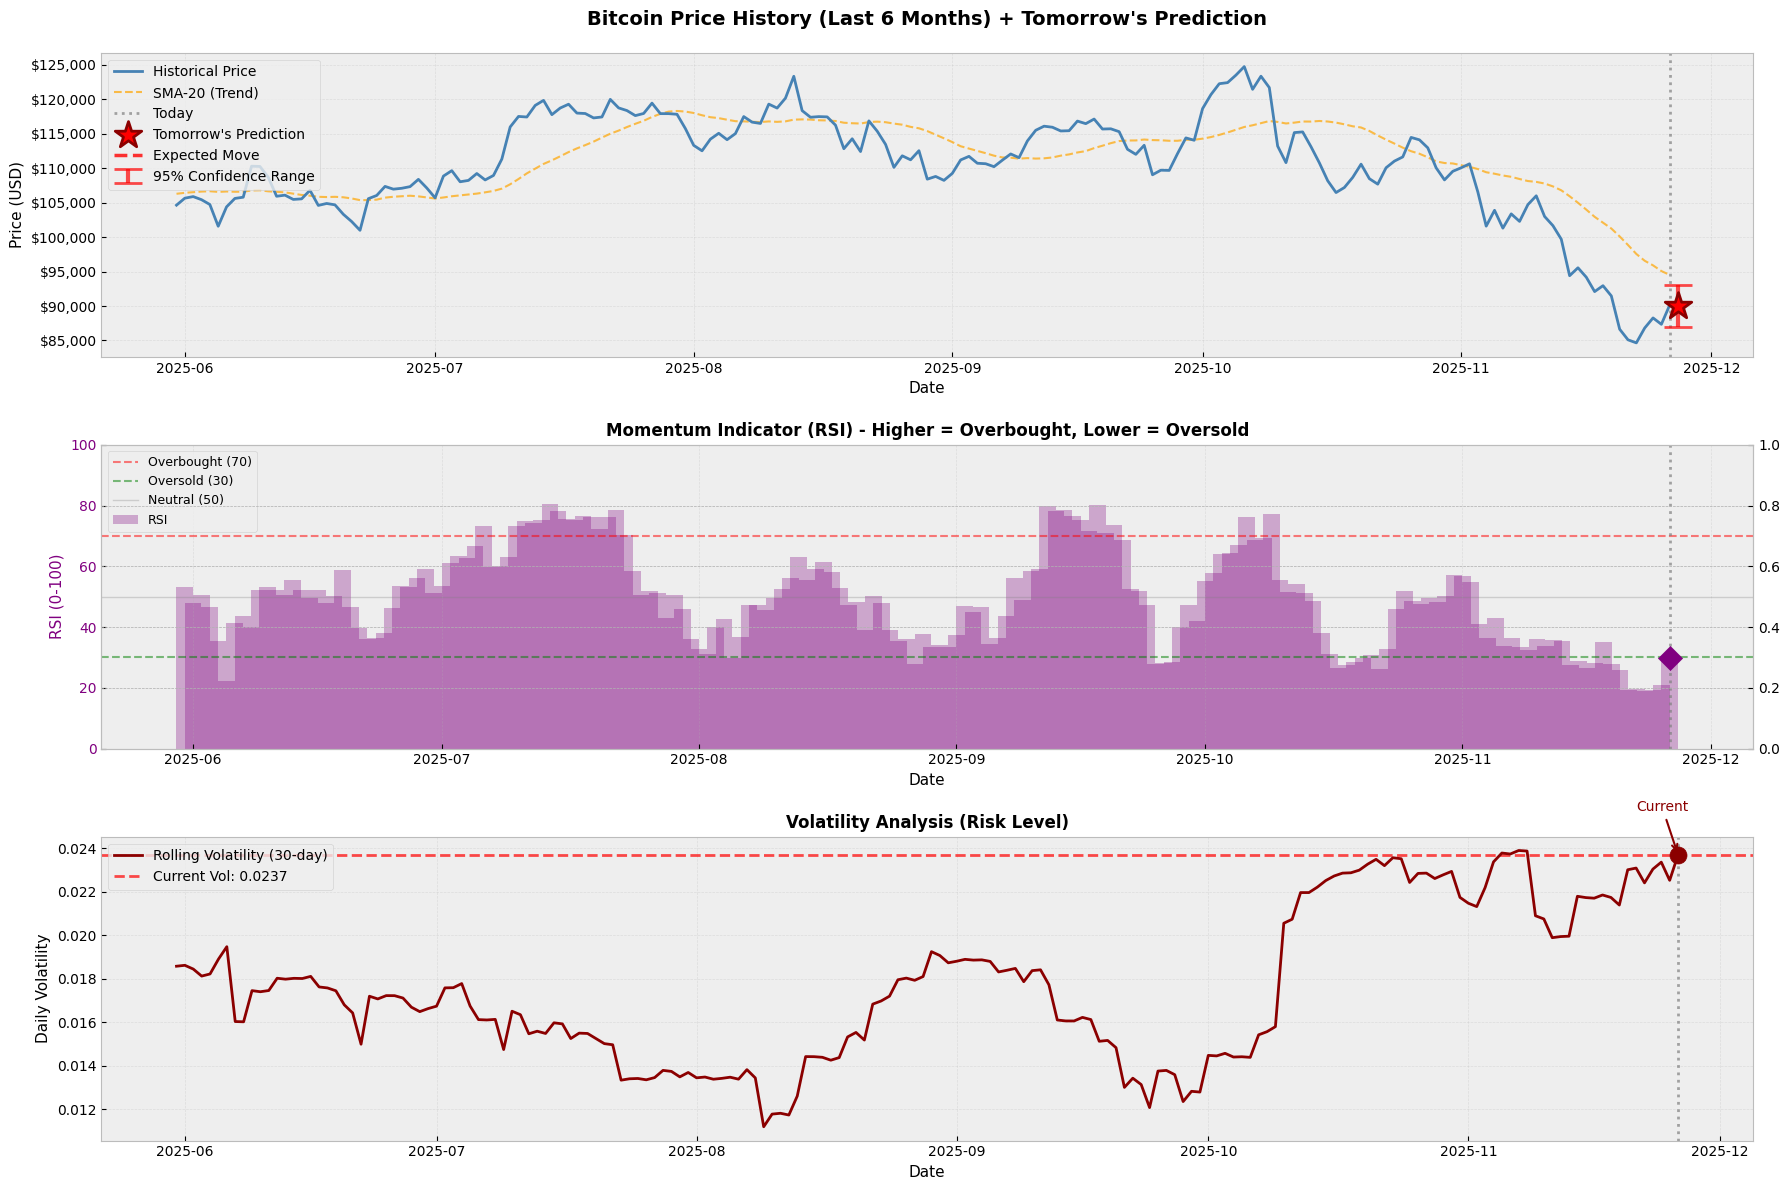


DETAILED PREDICTION SUMMARY

                    Metric               Value
             Current Price           $90149.21
 Expected Price (Tomorrow)           $89949.29
           Expected Change            $-199.92
         Expected Return %            -0.2218%
                                              
            RSI (Momentum)    29.72 (OVERSOLD)
       Volatility (30-day) 0.023709 (MODERATE)
Trend Distance from SMA-20  -4.62% (Below SMA)
                                              
            Probability UP              47.33%
          Probability DOWN              52.67%
                                              
               Base Signal                SELL
            Dynamic Signal                SELL
             Strong Signal             NEUTRAL
                                              
      Lower Bound (95% CI)           $87013.07
      Upper Bound (95% CI)           $92984.59
         Risk/Reward Ratio              1:1.03


Generating additional contex

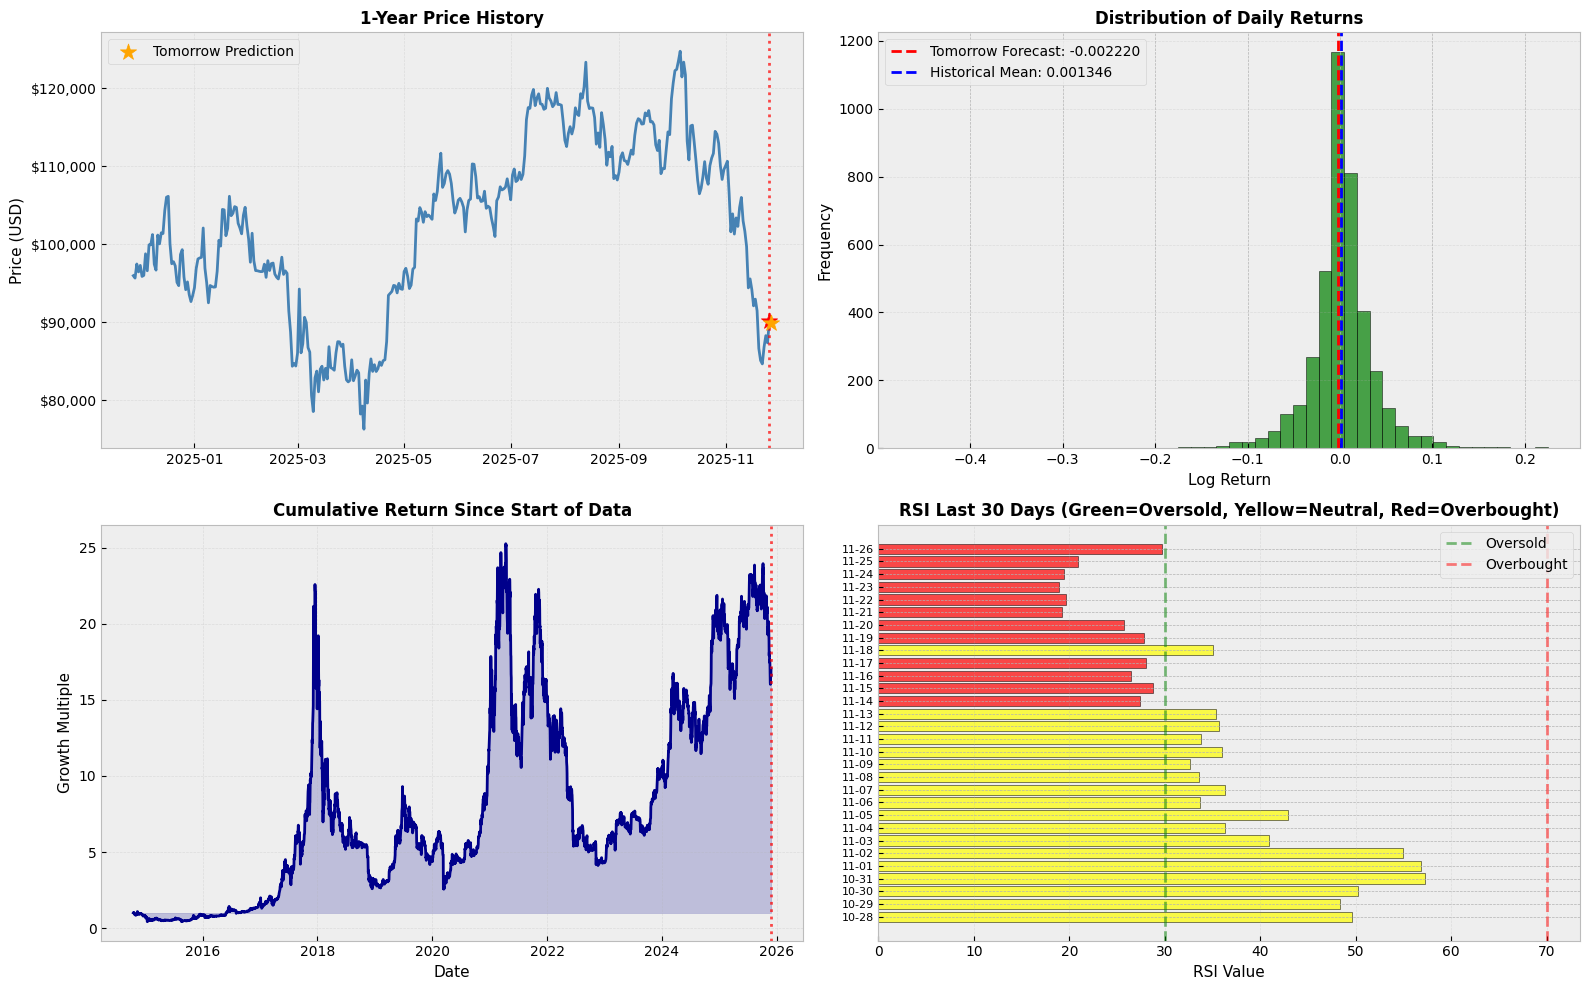


VISUALIZATION COMPLETE


In [229]:
# ============================================================================
# VISUALIZATION: HISTORICAL DATA + FUTURE PREDICTION
# ============================================================================

from datetime import datetime, timedelta
import matplotlib.patches as mpatches

print("\n" + "="*70)
print("CREATING VISUALIZATION: PRICE HISTORY + TOMORROW'S PREDICTION")
print("="*70)

# Create a comprehensive figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# Define the date range to show (last 6 months + prediction)
last_6_months = pd.Timestamp.now() - pd.Timedelta(days=180)
plot_data = btc[btc.index >= last_6_months].copy()

# Prepare tomorrow's data
tomorrow_date = pd.Timestamp(tomorrow)
tomorrow_close = expected_price_tomorrow
tomorrow_upper = price_upper
tomorrow_lower = price_lower

# ============================================================================
# SUBPLOT 1: Price History + Prediction with Confidence Range
# ============================================================================
ax1 = plt.subplot(3, 1, 1)

# Plot historical price
ax1.plot(plot_data.index, plot_data['Close'], label='Historical Price', 
         color='steelblue', linewidth=2, zorder=3)

# Plot SMA-20 for context
ax1.plot(plot_data.index, plot_data['SMA_20'], label='SMA-20 (Trend)', 
         color='orange', linewidth=1.5, alpha=0.7, linestyle='--')

# Add vertical line at today
today_date = pd.Timestamp(today)
ax1.axvline(today_date, color='gray', linestyle=':', linewidth=2, alpha=0.7, label='Today')

# Plot tomorrow's prediction point
ax1.scatter([tomorrow_date], [tomorrow_close], color='red', s=400, marker='*', 
           zorder=5, label='Tomorrow\'s Prediction', edgecolor='darkred', linewidths=2)

# Add confidence range as error bars (NOT fill_between with 2 points!)
# This properly shows uncertainty around the prediction point
ax1.errorbar([tomorrow_date], [tomorrow_close], 
            yerr=[[tomorrow_close - tomorrow_lower], [tomorrow_upper - tomorrow_close]],
            fmt='none', ecolor='red', elinewidth=3, capsize=10, capthick=2, 
            alpha=0.7, label='95% Confidence Range', zorder=4)

# Draw a subtle line from today's price to tomorrow's prediction
ax1.plot([today_date, tomorrow_date], [plot_data['Close'].iloc[-1], tomorrow_close],
        color='red', linewidth=2.5, linestyle='--', zorder=4, alpha=0.8, label='Expected Move')

ax1.set_title('Bitcoin Price History (Last 6 Months) + Tomorrow\'s Prediction', 
             fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Price (USD)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# ============================================================================
# SUBPLOT 2: Trading Signal Indicators
# ============================================================================
ax2 = plt.subplot(3, 1, 2)

# Plot RSI
ax2_twin = ax2.twinx()
ax2.bar(plot_data.index, plot_data['RSI'], color='purple', alpha=0.3, width=2, label='RSI')
ax2.axhline(70, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Overbought (70)')
ax2.axhline(30, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='Oversold (30)')
ax2.axhline(50, color='gray', linestyle='-', alpha=0.3, linewidth=1, label='Neutral (50)')

# Highlight tomorrow's RSI
ax2.scatter([today_date], [latest_rsi], color='purple', s=150, marker='D', zorder=5)

# Add vertical line at today
ax2.axvline(today_date, color='gray', linestyle=':', linewidth=2, alpha=0.7)

ax2.set_title('Momentum Indicator (RSI) - Higher = Overbought, Lower = Oversold', 
             fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('RSI (0-100)', fontsize=11, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim([0, 100])
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3, linestyle='--')

# ============================================================================
# SUBPLOT 3: Volatility + Probability
# ============================================================================
ax3 = plt.subplot(3, 1, 3)

# Plot volatility
ax3.plot(plot_data.index, plot_data['Rolling_Vol'], label='Rolling Volatility (30-day)', 
        color='darkred', linewidth=2, zorder=3)

# Add horizontal line for current volatility
ax3.axhline(latest_vol, color='red', linestyle='--', alpha=0.7, linewidth=2, 
           label=f'Current Vol: {latest_vol:.4f}')

# Add vertical line at today
ax3.axvline(today_date, color='gray', linestyle=':', linewidth=2, alpha=0.7)

# Add annotation for tomorrow's prediction
ax3.scatter([today_date], [latest_vol], color='darkred', s=150, marker='o', zorder=5)
ax3.annotate('Current', xy=(today_date, latest_vol), xytext=(today_date - pd.Timedelta(days=5), latest_vol + 0.002),
            arrowprops=dict(arrowstyle='->', color='darkred', lw=1.5), fontsize=10, color='darkred')

ax3.set_title('Volatility Analysis (Risk Level)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('Daily Volatility', fontsize=11)
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('btc_prediction_chart.png', dpi=300, bbox_inches='tight')
print("\n✓ Chart saved as 'btc_prediction_chart.png'")
plt.show()

# ============================================================================
# DETAILED SUMMARY TABLE
# ============================================================================
print("\n" + "="*70)
print("DETAILED PREDICTION SUMMARY")
print("="*70)

summary_table = pd.DataFrame({
    'Metric': [
        'Current Price',
        'Expected Price (Tomorrow)',
        'Expected Change',
        'Expected Return %',
        '',
        'RSI (Momentum)',
        'Volatility (30-day)',
        'Trend Distance from SMA-20',
        '',
        'Probability UP',
        'Probability DOWN',
        '',
        'Base Signal',
        'Dynamic Signal',
        'Strong Signal',
        '',
        'Lower Bound (95% CI)',
        'Upper Bound (95% CI)',
        'Risk/Reward Ratio'
    ],
    'Value': [
        f'${last_price:.2f}',
        f'${tomorrow_close:.2f}',
        f'${expected_price_move:.2f}',
        f'{expected_return_pct:.4f}%',
        '',
        f'{latest_rsi:.2f} (OVERSOLD)' if latest_rsi < 30 else f'{latest_rsi:.2f}',
        f'{latest_vol:.6f} (MODERATE)',
        f'{latest_trend*100:.2f}% (Below SMA)',
        '',
        f'{prob_up_tomorrow:.2%}',
        f'{prob_down_tomorrow:.2%}',
        '',
        signal_base,
        signal_dynamic,
        signal_strong,
        '',
        f'${tomorrow_lower:.2f}',
        f'${tomorrow_upper:.2f}',
        f'1:{abs((tomorrow_upper - tomorrow_close) / (tomorrow_close - tomorrow_lower)):.2f}'
    ]
})

print("\n" + summary_table.to_string(index=False))

# ============================================================================
# ADDITIONAL CONTEXT CHART: Year-to-Date Performance
# ============================================================================
print("\n\nGenerating additional context chart...")

fig2, axes = plt.subplots(2, 2, figsize=(16, 10))

# Chart 1: Year-to-Date Price
year_start = pd.Timestamp.now() - pd.Timedelta(days=365)
ytd_data = btc[btc.index >= year_start].copy()

ax = axes[0, 0]
ax.plot(ytd_data.index, ytd_data['Close'], color='steelblue', linewidth=2)
ax.axvline(today_date, color='red', linestyle=':', linewidth=2, alpha=0.7)
ax.scatter([today_date], [last_price], color='red', s=150, marker='*', zorder=5)
ax.scatter([tomorrow_date], [tomorrow_close], color='orange', s=150, marker='*', zorder=5, label='Tomorrow Prediction')
ax.set_title('1-Year Price History', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=11)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax.grid(True, alpha=0.3)
ax.legend()

# Chart 2: Daily Returns Distribution
ax = axes[0, 1]
ax.hist(btc['LogReturn'], bins=50, color='green', alpha=0.7, edgecolor='black')
ax.axvline(forecast_mean, color='red', linestyle='--', linewidth=2, label=f'Tomorrow Forecast: {forecast_mean:.6f}')
ax.axvline(btc['LogReturn'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Historical Mean: {btc["LogReturn"].mean():.6f}')
ax.set_title('Distribution of Daily Returns', fontsize=12, fontweight='bold')
ax.set_xlabel('Log Return', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Chart 3: Cumulative Return from Start
ax = axes[1, 0]
cumulative_return = (1 + btc['LogReturn']).cumprod()
ax.plot(btc.index, cumulative_return, color='darkblue', linewidth=2)
ax.axvline(today_date, color='red', linestyle=':', linewidth=2, alpha=0.7)
ax.fill_between(btc.index, 1, cumulative_return, alpha=0.2, color='darkblue')
ax.set_title('Cumulative Return Since Start of Data', fontsize=12, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Growth Multiple', fontsize=11)
ax.grid(True, alpha=0.3)

# Chart 4: Signal Confidence Heatmap (Last 30 days)
ax = axes[1, 1]
last_30 = btc['RSI'].tail(30)
colors_heat = ['red' if x < 30 else 'green' if x > 70 else 'yellow' for x in last_30]
bars = ax.barh(range(len(last_30)), last_30, color=colors_heat, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(last_30)))
ax.set_yticklabels([d.strftime('%m-%d') for d in last_30.index], fontsize=8)
ax.axvline(30, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Oversold')
ax.axvline(70, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Overbought')
ax.set_title('RSI Last 30 Days (Green=Oversold, Yellow=Neutral, Red=Overbought)', fontsize=12, fontweight='bold')
ax.set_xlabel('RSI Value', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('btc_additional_context.png', dpi=300, bbox_inches='tight')
print("✓ Additional context chart saved as 'btc_additional_context.png'")
plt.show()

print("\n" + "="*70)
print("VISUALIZATION COMPLETE")
print("="*70)